In [1]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from torch_geometric.data import Data
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [2]:
import sascorer

In [3]:
torch.set_default_device('cuda')

In [4]:
from constants import *

In [5]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn
from molecularmetrics import MolecularMetrics

In [6]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv", nrows=10_000)
gdb9=pd.read_csv("gdb9_shuffled.csv", nrows=10_000)
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [7]:
gdb9.head(5)

,smiles,qed,logP
0,CC1C(=O)NC([NH-])=C1N,0.476219,-0.0677
1,C#CCc1cc[nH]c1O,0.531797,0.8960
2,CO[C@H]1[C@H]2O[C@@H](C)[C@]21O,0.521381,-0.4666
3,CCC[C@H]1C[C@H]1C(N)=O,0.601215,0.9079
4,O=C1O[C@H]2[C@H]3CC[C@@H]1[C@H]32,0.441104,0.5678


In [8]:
zinc250k.head(5)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [9]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

# Atom count (with atomic numbers)
![atom_count](atom_counts.png "Atom Count")

In [10]:
def graph_from_smiles(smiles,return_mol=False,typ=None):
    rdkit_mol=Chem.MolFromSmiles(smiles)
    X=[list(MOLS.keys()).index(i.GetAtomicNum()) for i in rdkit_mol.GetAtoms() if i.GetAtomicNum()!=1]
    N=len(X)
    A=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            try:
                A[i,j]=BONDS[rdkit_mol.GetBondBetweenAtoms(i,j).GetBondType()]
            except:
                pass
    X=nn.functional.one_hot(torch.tensor(X), num_classes=len(MOLS))
    A=nn.functional.one_hot(A.to(int), num_classes=len(BONDS)).permute(-1,0,1)
    if typ is not None:
        X = X.to(typ)
        A = A.to(typ)
    if return_mol: 
        return X,A,rdkit_mol
    return X,A

In [11]:
def pyg_graph_from_graph(x,a):
    edge_index=a.nonzero(as_tuple=False).t()
    data = Data(x=x, edge_index=edge_index)
    return data

In [13]:
pyg_graph_from_graph(*graph_from_smiles("O=C=O",typ=torch.float32))

Data(x=[3, 4], edge_index=[3, 9])

In [12]:
def minibatch(graphs):
    combined_x=torch.cat([x for x,_ in graphs],dim=-2)
    n=[a.shape[-1] for _,a in graphs]
    combined_a=torch.zeros(graphs[0][1].shape[0],sum(n),sum(n))
    cumsum=0
    for n_,a in zip(n,[a for _,a in graphs]):
        combined_a[:,cumsum:cumsum+n_,cumsum:cumsum+n_]=a
        cumsum+=n_
    return (combined_x,combined_a), n

In [13]:
def mol_from_graph(x,a,strict=True,print_errors=False):
    assert a.shape[-3]==len(BONDS), "a: [N_BONDS, N_ATOMS, N_ATOMS]"
    assert len(a.shape)==3 or (len(a.shape)==4 and a.shape[0]==1), "batched operation not supported"
    if len(a.shape)==4:
        a=a[0]
        x=x[0]
    X_map=[*MOLS.keys()]
    iBOND = {BONDS[k]:k for k in BONDS}
    mol = Chem.RWMol()
    bonds=frozenset([])
    for node_label in x:
        mol.AddAtom(Chem.Atom(X_map[node_label.argmax().detach().cpu().numpy()]))

    for t,r,c in a[1:,:,:].argwhere().detach().cpu().numpy().tolist():
        if frozenset([r,c]) in bonds: continue
        if r==c: continue
        mol.AddBond(r, c, iBOND[t+1])#t+1 because t=0 now maps to SINGLEBOND because of a[1:,:,:]
        bonds |= frozenset([frozenset([r,c])])
        
    if strict:
        try:
            Chem.SanitizeMol(mol)
        except:
            mol = None
            if print_errors:
                print("error in Chem.SanitizeMol")

    return mol

In [14]:
def sample_gumbel(x,a,temperature=1.0,hard=False,method=None):
    x = nn.functional.gumbel_softmax(x,tau=temperature,hard=hard,dim=-1)
    a = nn.functional.gumbel_softmax(a,tau=temperature,hard=hard,dim=-3)
    return (x,a)

In [15]:
def reward(mol,norm=True):
    rr=1
    for m in ('logp','sas','qed'):
        if m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores([mol], norm=norm)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores([mol], norm=norm)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores([mol], norm=norm)
    return rr[0]

In [16]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size())
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    #print('dydx',dydx.sum().detach().item())
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.linalg.norm(dydx, dim=1, ord=2)
    res = ((dydx_l2norm - 1) ** 2).mean()
    #print('res',res.detach().item())
    return res

In [17]:
class Solver:
    def __init__(self, G, D, R, z_dim, generator_steps=1, lr=1e-3, lambda_wgan=WGAN_BIAS_LAMBDA, lambda_gp=GP_LAMBDA, loss_ema_n=200):
        self.G=G
        self.D=D
        self.R=R
        self.G_opt=torch.optim.AdamW(self.G.parameters(),lr=lr)
        self.D_opt=torch.optim.AdamW(self.D.parameters(),lr=lr)
        self.R_opt=torch.optim.AdamW(self.R.parameters(),lr=lr)
        self.z_dim=z_dim
        self.generator_steps=generator_steps
        self.lambda_wgan=lambda_wgan
        self.lambda_gp=lambda_gp
        self.loss_ema_n=loss_ema_n
    def train(self, dataset, ema_n=200, max_iters=-1):
        graphs = [graph_from_smiles(s,return_mol=True) for s in tqdm(dataset['smiles'][:max_iters],desc='converting graph from smiles...')]
        iterator = tqdm(graphs, desc='training', total=max_iters if max_iters>=0 else None)
        loss_ema=0
        las=[]
        lbs=[]
        lcs=[]
        lds=[]
        les=[]
        loss_sums=[]
        for real_x,real_a,real_mol in iterator:#graphs:
            if max_iters==0: break
            max_iters-=1
            z=sample(self.z_dim)
            real_x=real_x.to(torch.float32).unsqueeze(0)
            real_a=real_a.to(torch.float32).unsqueeze(0)
            
            # =======================
            #   train discriminator
            # =======================
            #print("=== train discriminator")

            # TODO: graph reward
            
            D_x = self.D((real_x,real_a))
            #print("D_x",D_x)
            (fake_x, fake_a) = self.G(z)
            fake_x = fake_x.detach()#detach because we dont want to nudge generator parameter in this part
            fake_a = fake_a.detach()
            #print('fake.sum()',fake_x.sum().item(), fake_a.sum().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            eps = torch.rand([])
            fake_n=sampled_fake_a.shape[-1]
            real_n=real_a.shape[-1]
            if real_n>fake_n:
                fake_a_tmp = torch.zeros_like(real_a)
                fake_a_tmp[...,:,:fake_n,:fake_n]=fake_a
                fake_x_tmp = torch.rand_like(real_x)/1e9
                fake_x_tmp[...,:fake_x.shape[-2],:]=fake_x
                sampled_fake_a=fake_a_tmp
                sampled_fake_x=fake_x_tmp
            elif real_n!=fake_n:
                real_a_tmp = torch.zeros_like(sampled_fake_a)
                real_a_tmp[...,:,:real_n,:real_n]=real_a
                real_x_tmp = torch.rand_like(sampled_fake_x)/1e9
                real_x_tmp[...,:real_x.shape[-2],:]=real_x
                real_a=real_a_tmp
                real_x=real_x_tmp
            #print('real',real_x.shape,real_a.shape)
            #print('sampled_fake',sampled_fake_x.shape,sampled_fake_a.shape)
            (x_hat_x, x_hat_a) = ( #x_hat = e*fake+(1-e)*real where e~U(0,1)
                (eps*sampled_fake_x + (1-eps)*real_x).detach().requires_grad_(True),# 
                (eps*sampled_fake_a + (1-eps)*real_a).detach().requires_grad_(True),# 
            )
            D_x_hat = self.D((x_hat_x, x_hat_a))
            gp_loss = self.lambda_gp*(gradient_penalty(D_x_hat,x_hat_x))#+gradient_penalty(D_x_hat,x_hat_a))
            loss_D = D_G_z-D_x#+gp_loss #GRADIENT PENALTY LOSS IS MAIN CULPRIT FOR NAN
            #if it errors because loss_D is not a scalar, then gp_loss calculations needs a .mean()
            #although, it shouldn't happen when batching has not been implemented
            self.D.zero_grad(set_to_none=True)
            loss_D.backward()
            self.D_opt.step()
            
            # ===================
            #   train rewardnet
            # ===================
            #print("=== train rewardnet")

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_V = (R_x - real_reward).abs() + (R_G_z - fake_reward).abs()# <- I'm half afraid that this part will induce too much noice.
                                              # Isn't |R(x)-reward(x)| enough? Can't find it in the paper about this
            self.R.zero_grad(set_to_none=True)
            loss_V.backward()
            self.R_opt.step()
            
            # ===================
            #   train generator
            # =================== 
            #print("=== train generator")
            for param in self.D.parameters():
                param.requires_grad = False
            for param in self.R.parameters():
                param.requires_grad = False
                
            for _ in range(self.generator_steps):
                z=sample(self.z_dim)
                (fake_x, fake_a) = self.G(z)
                #print('fake.sum()',fake_x.sum().detach().item(), fake_a.sum().detach().item())
                (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
                D_G_z = self.D((sampled_fake_x, sampled_fake_a))
                #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
                #print(fake_x.sum(),sampled_fake_x.sum())
                loss_G_wgan = -D_G_z
    
                real_reward = reward(real_mol)
                fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))
    
                R_G_z = self.R((sampled_fake_x, sampled_fake_a))
                
                loss_RL = -R_G_z
    
                # I have no idea what alpha is. I dont think it's in the paper
                alpha = 1#torch.abs(loss_G_wgan.detach() / (loss_RL.detach()+1e-9)).detach()
                loss_molgan = self.lambda_wgan * loss_G_wgan + (1 - self.lambda_wgan) * alpha * loss_RL
                la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), loss_RL.detach().cpu())
                self.G.zero_grad(set_to_none=True)
                loss_molgan.backward()
                self.G_opt.step()
            
            for param in self.D.parameters():
                param.requires_grad = True
            for param in self.R.parameters():
                param.requires_grad = True
                
            la=float(la)
            lb=float(lb)
            lc=float(lc)
            ld=float(ld)
            le=float(le)
            loss_sum = float(loss_molgan.detach().cpu()+loss_V.detach().cpu()+loss_D.detach().cpu())
            
            loss_ema = (1-1/ema_n)*loss_ema + loss_sum/ema_n
            #print(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")


            las.append(la)
            lbs.append(lb)
            lcs.append(lc)
            lds.append(ld)
            les.append(le)
            loss_sums.append(loss_sum)

            
            iterator.set_description(f"loss:{loss_ema:.2f} RL loss:{le:.2f}")# loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")
        return las, lbs, lcs, lds, les, loss_sums


In [31]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [32]:
Z_DIM=32
g = G.Generator(Z_DIM, [128, 256, 512], [256], [256], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([128, 64], [128], [128], [128, 64])
r = R.Rewarder([128, 64], [128], [128], [128, 64])

#g = G.Generator(32, [128, 256, 512], [], [], 9)
##input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
#d = D.Discriminator([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])
#r = R.Rewarder([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])

In [33]:
solver = Solver(g,d,r,Z_DIM,generator_steps=3,lr=1e-3)

In [34]:
m1=graph_from_smiles("O=C=O", typ=torch.float32)
m2=graph_from_smiles("CC", typ=torch.float32)

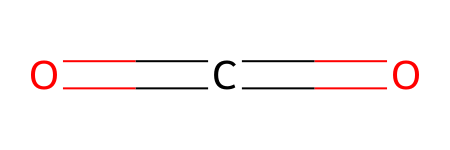

In [35]:
Chem.MolFromSmiles("O=C=O")

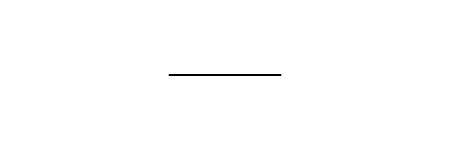

In [36]:
Chem.MolFromSmiles("CC")

In [48]:
m3,minibatch_sizes=minibatch((m1,m2,m1))

In [51]:
r(m3,minibatch_sizes=minibatch_sizes)

h: torch.Size([3, 128])


tensor([[0.5000],
        [0.4930],
        [0.4901]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [52]:
result=solver.train(gdb9,max_iters=10_000)


converting graph from smiles...: 100%|██████████████████████████████████████████| 10000/10000 [00:16<00:00, 594.67it/s]

training:   0%|                                                                              | 0/10000 [00:00<?, ?it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:0.00 RL loss:-0.35:   0%|                                                       | 1/10000 [00:00<49:59,  3.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.00 RL loss:-0.50:   0%|                                                      | 5/10000 [00:00<16:09, 10.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.00 RL loss:-0.08:   0%|                                                      | 7/10000 [00:00<14:00, 11.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.04 RL loss:-0.06:   0%|                                                     | 11/10000 [00:00<12:13, 13.61it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-0.12 RL loss:-0.50:   0%|                                                     | 13/10000 [00:01<11:51, 14.03it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-0.20 RL loss:-0.02:   0%|                                                     | 17/10000 [00:01<12:02, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.34 RL loss:-0.50:   0%|                                                     | 19/10000 [00:01<12:09, 13.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.38 RL loss:-0.01:   0%|                                                     | 21/10000 [00:01<12:23, 13.42it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-0.51 RL loss:-0.01:   0%|▏                                                    | 25/10000 [00:01<12:22, 13.44it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.65 RL loss:-0.01:   0%|▏                                                    | 27/10000 [00:02<12:20, 13.47it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-0.76 RL loss:-0.01:   0%|▏                                                    | 29/10000 [00:02<12:29, 13.30it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-0.91 RL loss:-0.01:   0%|▏                                                    | 33/10000 [00:02<12:37, 13.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.09 RL loss:-0.01:   0%|▏                                                    | 35/10000 [00:02<12:33, 13.22it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.22 RL loss:-0.01:   0%|▏                                                    | 37/10000 [00:02<12:46, 13.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-1.37 RL loss:-0.01:   0%|▏                                                    | 41/10000 [00:03<12:36, 13.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.45 RL loss:-0.01:   0%|▏                                                    | 43/10000 [00:03<12:43, 13.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.65 RL loss:-0.01:   0%|▏                                                    | 45/10000 [00:03<12:32, 13.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.75 RL loss:-0.01:   0%|▎                                                    | 49/10000 [00:03<12:25, 13.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-1.96 RL loss:-0.01:   1%|▎                                                    | 51/10000 [00:04<12:22, 13.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-2.17 RL loss:-0.01:   1%|▎                                                    | 53/10000 [00:04<12:25, 13.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-2.31 RL loss:-0.01:   1%|▎                                                    | 57/10000 [00:04<12:28, 13.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-2.53 RL loss:-0.01:   1%|▎                                                    | 59/10000 [00:04<12:31, 13.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-2.67 RL loss:-0.01:   1%|▎                                                    | 61/10000 [00:04<12:26, 13.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-2.85 RL loss:-0.00:   1%|▎                                                    | 65/10000 [00:05<12:26, 13.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.08 RL loss:-0.00:   1%|▎                                                    | 67/10000 [00:05<12:28, 13.27it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.24 RL loss:-0.00:   1%|▎                                                    | 69/10000 [00:05<12:33, 13.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-3.37 RL loss:-0.50:   1%|▍                                                    | 73/10000 [00:05<12:23, 13.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.57 RL loss:-0.00:   1%|▍                                                    | 75/10000 [00:05<12:37, 13.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.72 RL loss:-0.01:   1%|▍                                                    | 79/10000 [00:06<12:17, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.80 RL loss:-0.01:   1%|▍                                                    | 79/10000 [00:06<12:17, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-3.95 RL loss:-0.50:   1%|▍                                                    | 81/10000 [00:06<15:05, 10.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-4.13 RL loss:-0.01:   1%|▍                                                    | 85/10000 [00:06<14:31, 11.38it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-4.24 RL loss:-0.00:   1%|▍                                                    | 87/10000 [00:06<14:16, 11.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-4.50 RL loss:-0.01:   1%|▍                                                    | 89/10000 [00:07<14:00, 11.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-4.70 RL loss:-0.01:   1%|▍                                                    | 93/10000 [00:07<13:19, 12.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-4.87 RL loss:-0.00:   1%|▌                                                    | 95/10000 [00:07<13:27, 12.26it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-5.13 RL loss:-0.01:   1%|▌                                                    | 97/10000 [00:07<13:13, 12.47it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-5.40 RL loss:-0.00:   1%|▌                                                   | 101/10000 [00:07<12:04, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-5.61 RL loss:-0.00:   1%|▌                                                   | 103/10000 [00:08<11:44, 14.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-5.89 RL loss:-0.00:   1%|▌                                                   | 107/10000 [00:08<11:25, 14.43it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-6.11 RL loss:-0.00:   1%|▌                                                   | 109/10000 [00:08<11:55, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-6.30 RL loss:-0.00:   1%|▌                                                   | 111/10000 [00:08<12:25, 13.26it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-6.51 RL loss:-0.00:   1%|▌                                                   | 115/10000 [00:08<12:22, 13.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-6.80 RL loss:-0.00:   1%|▌                                                   | 117/10000 [00:09<11:54, 13.83it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-7.03 RL loss:-0.00:   1%|▋                                                   | 121/10000 [00:09<11:58, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-7.31 RL loss:-0.00:   1%|▋                                                   | 123/10000 [00:09<11:35, 14.20it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-7.54 RL loss:-0.50:   1%|▋                                                   | 127/10000 [00:09<11:48, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-7.77 RL loss:-0.00:   1%|▋                                                   | 129/10000 [00:09<11:32, 14.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-8.06 RL loss:-0.00:   1%|▋                                                   | 133/10000 [00:10<11:03, 14.87it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-8.36 RL loss:-0.00:   1%|▋                                                   | 135/10000 [00:10<10:59, 14.95it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-8.66 RL loss:-0.00:   1%|▋                                                   | 139/10000 [00:10<11:00, 14.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-8.96 RL loss:-0.00:   1%|▋                                                   | 141/10000 [00:10<11:01, 14.90it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-9.19 RL loss:-0.00:   1%|▊                                                   | 145/10000 [00:10<11:24, 14.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-9.50 RL loss:-0.00:   1%|▊                                                   | 147/10000 [00:11<11:38, 14.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-9.83 RL loss:-0.00:   2%|▊                                                   | 151/10000 [00:11<11:46, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-10.13 RL loss:-0.00:   2%|▊                                                  | 153/10000 [00:11<11:33, 14.21it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-10.27 RL loss:-0.00:   2%|▊                                                  | 155/10000 [00:11<11:51, 13.84it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-10.59 RL loss:-0.00:   2%|▊                                                  | 159/10000 [00:12<12:07, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-10.91 RL loss:-0.00:   2%|▊                                                  | 161/10000 [00:12<11:48, 13.89it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-10.98 RL loss:-0.00:   2%|▊                                                  | 165/10000 [00:12<11:20, 14.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-11.33 RL loss:-0.00:   2%|▊                                                  | 167/10000 [00:12<11:13, 14.60it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-11.50 RL loss:-0.50:   2%|▊                                                  | 171/10000 [00:12<10:57, 14.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-11.83 RL loss:-0.00:   2%|▉                                                  | 173/10000 [00:13<10:57, 14.95it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-12.16 RL loss:-0.00:   2%|▉                                                  | 177/10000 [00:13<11:03, 14.81it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-12.49 RL loss:-0.00:   2%|▉                                                  | 179/10000 [00:13<11:11, 14.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-12.74 RL loss:-0.00:   2%|▉                                                  | 183/10000 [00:13<11:02, 14.82it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-13.08 RL loss:-0.50:   2%|▉                                                  | 185/10000 [00:13<10:56, 14.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-13.34 RL loss:-0.00:   2%|▉                                                  | 189/10000 [00:14<11:08, 14.67it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-13.60 RL loss:-0.00:   2%|▉                                                  | 191/10000 [00:14<10:57, 14.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-13.85 RL loss:-0.00:   2%|▉                                                  | 195/10000 [00:14<10:46, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-14.20 RL loss:-0.00:   2%|█                                                  | 197/10000 [00:14<10:43, 15.22it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-14.47 RL loss:-0.00:   2%|█                                                  | 201/10000 [00:14<10:29, 15.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-14.81 RL loss:-0.00:   2%|█                                                  | 203/10000 [00:14<10:24, 15.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-15.15 RL loss:-0.00:   2%|█                                                  | 207/10000 [00:15<11:26, 14.27it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-15.51 RL loss:-0.00:   2%|█                                                  | 209/10000 [00:15<11:27, 14.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-15.67 RL loss:-0.00:   2%|█                                                  | 213/10000 [00:15<11:18, 14.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-15.91 RL loss:-0.00:   2%|█                                                  | 215/10000 [00:15<11:19, 14.39it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-16.07 RL loss:-0.00:   2%|█                                                  | 219/10000 [00:16<11:50, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-16.24 RL loss:-0.00:   2%|█▏                                                 | 221/10000 [00:16<11:32, 14.13it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-16.63 RL loss:-0.00:   2%|█▏                                                 | 225/10000 [00:16<10:58, 14.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-17.02 RL loss:-0.00:   2%|█▏                                                 | 227/10000 [00:16<10:55, 14.91it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-17.27 RL loss:-0.00:   2%|█▏                                                 | 231/10000 [00:16<10:38, 15.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-17.55 RL loss:-0.00:   2%|█▏                                                 | 233/10000 [00:17<10:39, 15.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-17.82 RL loss:-0.00:   2%|█▏                                                 | 237/10000 [00:17<10:30, 15.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-18.08 RL loss:-0.00:   2%|█▏                                                 | 239/10000 [00:17<10:36, 15.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-18.36 RL loss:-0.00:   2%|█▏                                                 | 243/10000 [00:17<10:29, 15.51it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-18.75 RL loss:-0.00:   2%|█▏                                                 | 245/10000 [00:17<10:32, 15.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-19.03 RL loss:-0.00:   2%|█▎                                                 | 249/10000 [00:18<10:30, 15.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-19.42 RL loss:-0.00:   3%|█▎                                                 | 251/10000 [00:18<10:37, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-19.70 RL loss:-0.00:   3%|█▎                                                 | 255/10000 [00:18<10:32, 15.40it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-19.95 RL loss:-0.00:   3%|█▎                                                 | 257/10000 [00:18<10:29, 15.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-20.22 RL loss:-0.00:   3%|█▎                                                 | 261/10000 [00:18<10:21, 15.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-20.63 RL loss:-0.00:   3%|█▎                                                 | 263/10000 [00:19<10:22, 15.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-21.01 RL loss:-0.00:   3%|█▎                                                 | 267/10000 [00:19<10:49, 14.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-21.28 RL loss:-0.00:   3%|█▎                                                 | 269/10000 [00:19<10:48, 15.01it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-21.53 RL loss:-0.00:   3%|█▍                                                 | 273/10000 [00:19<10:25, 15.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-21.80 RL loss:-0.00:   3%|█▍                                                 | 275/10000 [00:19<10:28, 15.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-22.08 RL loss:-0.00:   3%|█▍                                                 | 279/10000 [00:19<10:23, 15.59it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-22.48 RL loss:-0.00:   3%|█▍                                                 | 281/10000 [00:20<10:58, 14.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-22.76 RL loss:-0.00:   3%|█▍                                                 | 285/10000 [00:20<11:19, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-23.03 RL loss:-0.00:   3%|█▍                                                 | 287/10000 [00:20<11:06, 14.58it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-23.05 RL loss:-0.50:   3%|█▍                                                 | 291/10000 [00:20<11:33, 14.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-23.33 RL loss:-0.50:   3%|█▍                                                 | 293/10000 [00:21<11:13, 14.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-23.76 RL loss:-0.00:   3%|█▌                                                 | 297/10000 [00:21<11:51, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-24.04 RL loss:-0.00:   3%|█▌                                                 | 299/10000 [00:21<12:48, 12.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-24.32 RL loss:-0.00:   3%|█▌                                                 | 301/10000 [00:21<12:44, 12.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-24.69 RL loss:-0.00:   3%|█▌                                                 | 305/10000 [00:21<12:17, 13.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-24.96 RL loss:-0.00:   3%|█▌                                                 | 307/10000 [00:22<12:14, 13.20it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-25.12 RL loss:-0.00:   3%|█▌                                                 | 309/10000 [00:22<12:41, 12.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-25.52 RL loss:-0.00:   3%|█▌                                                 | 311/10000 [00:22<14:00, 11.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-25.67 RL loss:-0.00:   3%|█▌                                                 | 313/10000 [00:22<13:34, 11.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-26.08 RL loss:-0.00:   3%|█▌                                                 | 317/10000 [00:22<13:19, 12.11it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-26.36 RL loss:-0.00:   3%|█▋                                                 | 319/10000 [00:23<13:03, 12.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-26.63 RL loss:-0.00:   3%|█▋                                                 | 321/10000 [00:23<13:06, 12.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-26.91 RL loss:-0.00:   3%|█▋                                                 | 325/10000 [00:23<12:27, 12.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-26.92 RL loss:-0.00:   3%|█▋                                                 | 327/10000 [00:23<11:42, 13.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-27.37 RL loss:-0.00:   3%|█▋                                                 | 329/10000 [00:23<11:22, 14.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-27.80 RL loss:-0.00:   3%|█▋                                                 | 333/10000 [00:24<11:07, 14.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-28.09 RL loss:-0.00:   3%|█▋                                                 | 335/10000 [00:24<11:05, 14.52it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-28.52 RL loss:-0.00:   3%|█▋                                                 | 339/10000 [00:24<10:35, 15.19it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-28.93 RL loss:-0.00:   3%|█▋                                                 | 341/10000 [00:24<10:31, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-29.33 RL loss:-0.00:   3%|█▊                                                 | 345/10000 [00:24<10:28, 15.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-29.73 RL loss:-0.00:   3%|█▊                                                 | 347/10000 [00:25<10:25, 15.43it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-30.17 RL loss:-0.00:   4%|█▊                                                 | 351/10000 [00:25<10:28, 15.36it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-30.45 RL loss:-0.00:   4%|█▊                                                 | 353/10000 [00:25<10:23, 15.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-30.73 RL loss:-0.00:   4%|█▊                                                 | 357/10000 [00:25<10:20, 15.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-31.13 RL loss:-0.00:   4%|█▊                                                 | 359/10000 [00:25<10:18, 15.59it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-31.41 RL loss:-0.50:   4%|█▊                                                 | 363/10000 [00:26<10:20, 15.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-31.70 RL loss:-0.00:   4%|█▊                                                 | 365/10000 [00:26<10:48, 14.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-31.99 RL loss:-0.00:   4%|█▉                                                 | 369/10000 [00:26<11:06, 14.45it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-32.42 RL loss:-0.00:   4%|█▉                                                 | 371/10000 [00:26<10:49, 14.83it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-32.85 RL loss:-0.00:   4%|█▉                                                 | 375/10000 [00:26<10:32, 15.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-33.14 RL loss:-0.00:   4%|█▉                                                 | 377/10000 [00:27<10:31, 15.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-33.44 RL loss:-0.00:   4%|█▉                                                 | 381/10000 [00:27<10:30, 15.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-33.56 RL loss:-0.00:   4%|█▉                                                 | 383/10000 [00:27<10:42, 14.97it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-34.03 RL loss:-0.00:   4%|█▉                                                 | 387/10000 [00:27<10:36, 15.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-34.45 RL loss:-0.00:   4%|█▉                                                 | 389/10000 [00:27<10:37, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-34.72 RL loss:-0.50:   4%|██                                                 | 393/10000 [00:28<10:31, 15.22it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-35.16 RL loss:-0.00:   4%|██                                                 | 395/10000 [00:28<10:41, 14.96it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-35.47 RL loss:-0.00:   4%|██                                                 | 399/10000 [00:28<10:38, 15.03it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-35.74 RL loss:-0.00:   4%|██                                                 | 401/10000 [00:28<10:29, 15.24it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-36.19 RL loss:-0.00:   4%|██                                                 | 405/10000 [00:28<10:33, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-36.31 RL loss:-0.00:   4%|██                                                 | 407/10000 [00:29<10:37, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-36.76 RL loss:-0.00:   4%|██                                                 | 411/10000 [00:29<10:21, 15.43it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-37.20 RL loss:-0.50:   4%|██                                                 | 413/10000 [00:29<10:36, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-37.47 RL loss:-0.00:   4%|██▏                                                | 417/10000 [00:29<10:30, 15.20it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-37.92 RL loss:-0.00:   4%|██▏                                                | 419/10000 [00:29<10:38, 15.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-38.04 RL loss:-0.00:   4%|██▏                                                | 423/10000 [00:30<10:43, 14.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-38.16 RL loss:-0.00:   4%|██▏                                                | 425/10000 [00:30<10:37, 15.02it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-38.30 RL loss:-0.00:   4%|██▏                                                | 429/10000 [00:30<10:38, 15.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-38.58 RL loss:-0.00:   4%|██▏                                                | 431/10000 [00:30<10:30, 15.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-38.87 RL loss:-0.00:   4%|██▏                                                | 435/10000 [00:30<10:26, 15.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-39.18 RL loss:-0.50:   4%|██▏                                                | 437/10000 [00:30<10:21, 15.38it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-39.28 RL loss:-0.00:   4%|██▏                                                | 441/10000 [00:31<10:18, 15.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-39.55 RL loss:-0.00:   4%|██▎                                                | 443/10000 [00:31<10:30, 15.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-40.04 RL loss:-0.00:   4%|██▎                                                | 447/10000 [00:31<10:22, 15.36it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-40.35 RL loss:-0.00:   4%|██▎                                                | 449/10000 [00:31<10:30, 15.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-40.62 RL loss:-0.00:   5%|██▎                                                | 453/10000 [00:31<10:21, 15.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-41.11 RL loss:-0.00:   5%|██▎                                                | 455/10000 [00:32<10:17, 15.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-41.57 RL loss:-0.00:   5%|██▎                                                | 459/10000 [00:32<10:25, 15.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-42.03 RL loss:-0.00:   5%|██▎                                                | 461/10000 [00:32<10:21, 15.34it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-42.47 RL loss:-0.00:   5%|██▎                                                | 465/10000 [00:32<10:23, 15.30it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-42.75 RL loss:-0.00:   5%|██▍                                                | 467/10000 [00:32<10:20, 15.36it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-43.23 RL loss:-0.00:   5%|██▍                                                | 471/10000 [00:33<10:17, 15.44it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-43.30 RL loss:-0.00:   5%|██▍                                                | 473/10000 [00:33<10:27, 15.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-43.59 RL loss:-0.00:   5%|██▍                                                | 477/10000 [00:33<10:25, 15.22it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-43.88 RL loss:-0.00:   5%|██▍                                                | 479/10000 [00:33<10:33, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-44.34 RL loss:-0.00:   5%|██▍                                                | 483/10000 [00:33<10:27, 15.16it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-44.86 RL loss:-0.00:   5%|██▍                                                | 485/10000 [00:34<10:56, 14.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-45.36 RL loss:-0.00:   5%|██▍                                                | 489/10000 [00:34<10:59, 14.42it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-45.83 RL loss:-0.00:   5%|██▌                                                | 491/10000 [00:34<10:36, 14.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-46.28 RL loss:-0.00:   5%|██▌                                                | 495/10000 [00:34<10:28, 15.11it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-46.55 RL loss:-0.00:   5%|██▌                                                | 497/10000 [00:34<10:21, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-46.57 RL loss:-0.50:   5%|██▌                                                | 501/10000 [00:35<10:22, 15.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-46.81 RL loss:-0.00:   5%|██▌                                                | 503/10000 [00:35<10:27, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-47.30 RL loss:-0.00:   5%|██▌                                                | 507/10000 [00:35<10:17, 15.37it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-47.79 RL loss:-0.00:   5%|██▌                                                | 509/10000 [00:35<10:24, 15.19it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-48.09 RL loss:-0.00:   5%|██▌                                                | 513/10000 [00:35<10:30, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-48.17 RL loss:-0.50:   5%|██▋                                                | 515/10000 [00:36<10:23, 15.22it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-48.64 RL loss:-0.00:   5%|██▋                                                | 519/10000 [00:36<10:24, 15.19it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-48.93 RL loss:-0.50:   5%|██▋                                                | 521/10000 [00:36<10:25, 15.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-49.43 RL loss:-0.00:   5%|██▋                                                | 525/10000 [00:36<10:21, 15.24it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-49.73 RL loss:-0.00:   5%|██▋                                                | 527/10000 [00:36<10:36, 14.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-49.99 RL loss:-0.50:   5%|██▋                                                | 531/10000 [00:37<10:29, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-50.49 RL loss:-0.00:   5%|██▋                                                | 533/10000 [00:37<10:17, 15.33it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-51.01 RL loss:-0.00:   5%|██▋                                                | 537/10000 [00:37<10:34, 14.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-51.51 RL loss:-0.00:   5%|██▋                                                | 539/10000 [00:37<10:39, 14.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-51.78 RL loss:-0.50:   5%|██▊                                                | 543/10000 [00:37<11:00, 14.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-52.27 RL loss:-0.00:   5%|██▊                                                | 545/10000 [00:38<10:58, 14.36it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-52.56 RL loss:-0.00:   5%|██▊                                                | 549/10000 [00:38<10:57, 14.37it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-52.84 RL loss:-0.00:   6%|██▊                                                | 551/10000 [00:38<11:00, 14.30it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-53.36 RL loss:-0.00:   6%|██▊                                                | 555/10000 [00:38<11:28, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-53.44 RL loss:-0.00:   6%|██▊                                                | 557/10000 [00:39<11:40, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-53.75 RL loss:-0.00:   6%|██▊                                                | 561/10000 [00:39<11:00, 14.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-54.02 RL loss:-0.00:   6%|██▊                                                | 563/10000 [00:39<10:45, 14.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-54.31 RL loss:-0.00:   6%|██▉                                                | 567/10000 [00:39<10:28, 15.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-54.34 RL loss:-0.00:   6%|██▉                                                | 569/10000 [00:39<10:28, 15.01it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-54.59 RL loss:-0.00:   6%|██▉                                                | 573/10000 [00:40<10:15, 15.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-55.11 RL loss:-0.00:   6%|██▉                                                | 575/10000 [00:40<10:15, 15.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-55.65 RL loss:-0.00:   6%|██▉                                                | 579/10000 [00:40<10:05, 15.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-56.14 RL loss:-0.00:   6%|██▉                                                | 581/10000 [00:40<10:01, 15.66it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-56.66 RL loss:-0.00:   6%|██▉                                                | 585/10000 [00:40<09:50, 15.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-56.93 RL loss:-0.00:   6%|██▉                                                | 587/10000 [00:40<09:51, 15.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-57.42 RL loss:-0.00:   6%|███                                                | 591/10000 [00:41<09:57, 15.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-57.70 RL loss:-0.00:   6%|███                                                | 593/10000 [00:41<09:56, 15.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-57.99 RL loss:-0.00:   6%|███                                                | 597/10000 [00:41<10:35, 14.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-58.51 RL loss:-0.50:   6%|███                                                | 599/10000 [00:41<10:47, 14.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-59.05 RL loss:-0.50:   6%|███                                                | 603/10000 [00:41<11:09, 14.04it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-59.12 RL loss:-0.00:   6%|███                                                | 605/10000 [00:42<11:21, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-59.46 RL loss:-0.00:   6%|███                                                | 607/10000 [00:42<11:26, 13.69it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-59.99 RL loss:-0.00:   6%|███                                                | 611/10000 [00:42<11:26, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-60.26 RL loss:-0.00:   6%|███▏                                               | 613/10000 [00:42<11:39, 13.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-60.78 RL loss:-0.50:   6%|███▏                                               | 617/10000 [00:43<11:31, 13.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-61.12 RL loss:-0.00:   6%|███▏                                               | 619/10000 [00:43<11:57, 13.08it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-61.38 RL loss:-0.00:   6%|███▏                                               | 621/10000 [00:43<11:50, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-61.90 RL loss:-0.00:   6%|███▏                                               | 625/10000 [00:43<11:49, 13.21it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-62.17 RL loss:-0.00:   6%|███▏                                               | 627/10000 [00:43<11:47, 13.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-62.42 RL loss:-0.00:   6%|███▏                                               | 631/10000 [00:44<11:37, 13.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-62.79 RL loss:-0.00:   6%|███▏                                               | 633/10000 [00:44<11:45, 13.28it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-63.31 RL loss:-0.00:   6%|███▏                                               | 635/10000 [00:44<11:41, 13.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-63.37 RL loss:-0.00:   6%|███▎                                               | 639/10000 [00:44<11:37, 13.42it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-63.84 RL loss:-0.00:   6%|███▎                                               | 641/10000 [00:44<11:31, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-64.08 RL loss:-0.00:   6%|███▎                                               | 645/10000 [00:45<11:35, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-64.11 RL loss:-0.00:   6%|███▎                                               | 647/10000 [00:45<11:36, 13.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-64.58 RL loss:-0.00:   6%|███▎                                               | 649/10000 [00:45<11:35, 13.44it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-64.67 RL loss:-0.00:   7%|███▎                                               | 653/10000 [00:45<11:33, 13.48it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-64.98 RL loss:-0.00:   7%|███▎                                               | 655/10000 [00:45<11:26, 13.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-65.51 RL loss:-0.00:   7%|███▎                                               | 659/10000 [00:46<11:12, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-65.79 RL loss:-0.00:   7%|███▎                                               | 661/10000 [00:46<11:15, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-66.05 RL loss:-0.00:   7%|███▍                                               | 665/10000 [00:46<11:11, 13.89it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-65.79 RL loss:-0.00:   7%|███▍                                               | 667/10000 [00:46<11:12, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-66.31 RL loss:-0.00:   7%|███▍                                               | 671/10000 [00:47<11:01, 14.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-66.61 RL loss:-0.00:   7%|███▍                                               | 673/10000 [00:47<11:02, 14.08it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-66.59 RL loss:-0.00:   7%|███▍                                               | 677/10000 [00:47<11:12, 13.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-66.69 RL loss:-0.00:   7%|███▍                                               | 679/10000 [00:47<11:15, 13.81it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-66.96 RL loss:-0.00:   7%|███▍                                               | 681/10000 [00:47<11:15, 13.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-67.22 RL loss:-0.00:   7%|███▍                                               | 685/10000 [00:48<11:15, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-67.47 RL loss:-0.00:   7%|███▌                                               | 687/10000 [00:48<11:20, 13.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-68.01 RL loss:-0.00:   7%|███▌                                               | 691/10000 [00:48<11:24, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-68.37 RL loss:-0.00:   7%|███▌                                               | 693/10000 [00:48<11:32, 13.44it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-68.62 RL loss:-0.00:   7%|███▌                                               | 695/10000 [00:48<11:27, 13.53it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-68.35 RL loss:-0.00:   7%|███▌                                               | 699/10000 [00:49<11:15, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-68.91 RL loss:-0.00:   7%|███▌                                               | 701/10000 [00:49<11:09, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-69.49 RL loss:-0.00:   7%|███▌                                               | 705/10000 [00:49<11:21, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-69.22 RL loss:-0.50:   7%|███▌                                               | 707/10000 [00:49<11:20, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-69.78 RL loss:-0.00:   7%|███▋                                               | 711/10000 [00:49<11:19, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-70.18 RL loss:-0.00:   7%|███▋                                               | 713/10000 [00:50<11:25, 13.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-70.66 RL loss:-0.00:   7%|███▋                                               | 715/10000 [00:50<11:27, 13.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-71.23 RL loss:-0.50:   7%|███▋                                               | 719/10000 [00:50<11:36, 13.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-70.99 RL loss:-0.00:   7%|███▋                                               | 721/10000 [00:50<11:29, 13.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-71.32 RL loss:-0.00:   7%|███▋                                               | 725/10000 [00:50<11:19, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-71.68 RL loss:-0.50:   7%|███▋                                               | 727/10000 [00:51<11:20, 13.63it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-72.24 RL loss:-0.00:   7%|███▋                                               | 729/10000 [00:51<11:15, 13.72it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-72.80 RL loss:-0.00:   7%|███▋                                               | 733/10000 [00:51<11:15, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-73.07 RL loss:-0.00:   7%|███▋                                               | 735/10000 [00:51<11:16, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-72.77 RL loss:-0.50:   7%|███▊                                               | 739/10000 [00:52<11:16, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-73.34 RL loss:-0.00:   7%|███▊                                               | 741/10000 [00:52<11:17, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-73.89 RL loss:-0.00:   7%|███▊                                               | 745/10000 [00:52<11:13, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-74.16 RL loss:-0.00:   7%|███▊                                               | 747/10000 [00:52<11:08, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-74.17 RL loss:-0.00:   8%|███▊                                               | 751/10000 [00:52<11:10, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-74.50 RL loss:-0.00:   8%|███▊                                               | 753/10000 [00:53<11:10, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-74.81 RL loss:-0.00:   8%|███▊                                               | 757/10000 [00:53<11:10, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-74.81 RL loss:-0.00:   8%|███▊                                               | 759/10000 [00:53<11:14, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-75.20 RL loss:-0.00:   8%|███▉                                               | 761/10000 [00:53<11:24, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-75.50 RL loss:-0.00:   8%|███▉                                               | 765/10000 [00:53<11:16, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-75.78 RL loss:-0.00:   8%|███▉                                               | 767/10000 [00:54<11:16, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-76.04 RL loss:-0.00:   8%|███▉                                               | 771/10000 [00:54<11:21, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-76.34 RL loss:-0.00:   8%|███▉                                               | 773/10000 [00:54<11:15, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-76.93 RL loss:-0.00:   8%|███▉                                               | 777/10000 [00:54<11:19, 13.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-77.20 RL loss:-0.00:   8%|███▉                                               | 779/10000 [00:55<11:18, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-77.47 RL loss:-0.00:   8%|███▉                                               | 783/10000 [00:55<11:10, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-77.56 RL loss:-0.00:   8%|████                                               | 785/10000 [00:55<11:29, 13.37it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-78.16 RL loss:-0.00:   8%|████                                               | 787/10000 [00:55<11:14, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-78.44 RL loss:-0.00:   8%|████                                               | 791/10000 [00:55<11:04, 13.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-78.71 RL loss:-0.00:   8%|████                                               | 793/10000 [00:56<11:05, 13.83it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-79.01 RL loss:-0.00:   8%|████                                               | 797/10000 [00:56<10:55, 14.03it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-79.60 RL loss:-0.00:   8%|████                                               | 799/10000 [00:56<11:01, 13.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-79.58 RL loss:-0.00:   8%|████                                               | 803/10000 [00:56<11:02, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-80.18 RL loss:-0.00:   8%|████                                               | 805/10000 [00:56<10:51, 14.12it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-80.54 RL loss:-0.00:   8%|████                                               | 807/10000 [00:57<10:46, 14.21it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-81.14 RL loss:-0.00:   8%|████▏                                              | 811/10000 [00:57<10:56, 14.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-81.70 RL loss:-0.00:   8%|████▏                                              | 813/10000 [00:57<10:57, 13.96it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-82.25 RL loss:-0.00:   8%|████▏                                              | 817/10000 [00:57<10:53, 14.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-82.17 RL loss:-0.00:   8%|████▏                                              | 819/10000 [00:57<10:52, 14.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-82.78 RL loss:-0.00:   8%|████▏                                              | 823/10000 [00:58<11:04, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-83.34 RL loss:-0.50:   8%|████▏                                              | 825/10000 [00:58<11:03, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-83.95 RL loss:-0.00:   8%|████▏                                              | 829/10000 [00:58<10:55, 13.98it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-84.51 RL loss:-0.00:   8%|████▏                                              | 831/10000 [00:58<11:02, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-85.09 RL loss:-0.00:   8%|████▎                                              | 835/10000 [00:58<11:08, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-85.68 RL loss:-0.00:   8%|████▎                                              | 837/10000 [00:59<11:03, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-86.06 RL loss:-0.00:   8%|████▎                                              | 839/10000 [00:59<11:08, 13.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-86.32 RL loss:-0.00:   8%|████▎                                              | 843/10000 [00:59<11:10, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-86.59 RL loss:-0.00:   8%|████▎                                              | 845/10000 [00:59<11:09, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-87.15 RL loss:-0.00:   8%|████▎                                              | 849/10000 [00:59<11:00, 13.85it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-87.76 RL loss:-0.00:   9%|████▎                                              | 851/10000 [01:00<10:52, 14.01it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-88.30 RL loss:-0.00:   9%|████▎                                              | 855/10000 [01:00<10:57, 13.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-88.54 RL loss:-0.00:   9%|████▎                                              | 857/10000 [01:00<10:59, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-88.61 RL loss:-0.00:   9%|████▍                                              | 859/10000 [01:00<11:09, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-89.15 RL loss:-0.50:   9%|████▍                                              | 863/10000 [01:01<11:03, 13.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-89.71 RL loss:-0.00:   9%|████▍                                              | 865/10000 [01:01<10:59, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-90.30 RL loss:-0.00:   9%|████▍                                              | 869/10000 [01:01<11:04, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-90.83 RL loss:-0.00:   9%|████▍                                              | 871/10000 [01:01<11:08, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-91.11 RL loss:-0.00:   9%|████▍                                              | 875/10000 [01:01<10:55, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-90.87 RL loss:-0.50:   9%|████▍                                              | 877/10000 [01:02<10:53, 13.96it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-91.42 RL loss:-0.00:   9%|████▍                                              | 879/10000 [01:02<10:56, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-91.34 RL loss:-0.00:   9%|████▌                                              | 883/10000 [01:02<11:03, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-91.06 RL loss:-0.00:   9%|████▌                                              | 885/10000 [01:02<11:10, 13.60it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-91.67 RL loss:-0.00:   9%|████▌                                              | 887/10000 [01:02<11:04, 13.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-91.92 RL loss:-0.00:   9%|████▌                                              | 891/10000 [01:03<11:06, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-92.09 RL loss:-0.00:   9%|████▌                                              | 893/10000 [01:03<11:02, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-92.49 RL loss:-0.00:   9%|████▌                                              | 895/10000 [01:03<10:55, 13.90it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-92.98 RL loss:-0.00:   9%|████▌                                              | 899/10000 [01:03<11:03, 13.72it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-93.54 RL loss:-0.00:   9%|████▌                                              | 901/10000 [01:03<11:00, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-93.76 RL loss:-0.00:   9%|████▌                                              | 905/10000 [01:04<11:06, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-94.34 RL loss:-0.00:   9%|████▋                                              | 907/10000 [01:04<11:12, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-94.94 RL loss:-0.00:   9%|████▋                                              | 911/10000 [01:04<11:06, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-95.50 RL loss:-0.00:   9%|████▋                                              | 913/10000 [01:04<11:04, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-95.44 RL loss:-0.00:   9%|████▋                                              | 917/10000 [01:04<11:08, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-95.51 RL loss:-0.50:   9%|████▋                                              | 919/10000 [01:05<11:11, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-96.10 RL loss:-0.00:   9%|████▋                                              | 921/10000 [01:05<11:10, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-96.36 RL loss:-0.00:   9%|████▋                                              | 925/10000 [01:05<10:49, 13.98it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-96.60 RL loss:-0.50:   9%|████▋                                              | 927/10000 [01:05<11:02, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-97.22 RL loss:-0.00:   9%|████▋                                              | 931/10000 [01:05<11:01, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-97.57 RL loss:-0.00:   9%|████▊                                              | 933/10000 [01:06<11:04, 13.64it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-98.18 RL loss:-0.00:   9%|████▊                                              | 935/10000 [01:06<11:04, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-98.43 RL loss:-0.50:   9%|████▊                                              | 939/10000 [01:06<10:58, 13.77it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-98.99 RL loss:-0.00:   9%|████▊                                              | 941/10000 [01:06<10:53, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-98.65 RL loss:-0.00:   9%|████▊                                              | 943/10000 [01:06<10:50, 13.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-98.89 RL loss:-0.00:   9%|████▊                                              | 947/10000 [01:07<11:04, 13.63it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-99.50 RL loss:-0.00:   9%|████▊                                              | 949/10000 [01:07<10:59, 13.73it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-99.75 RL loss:-0.00:  10%|████▊                                              | 953/10000 [01:07<11:04, 13.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-100.41 RL loss:-0.00:  10%|████▊                                             | 955/10000 [01:07<11:03, 13.64it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-100.58 RL loss:-0.00:  10%|████▊                                             | 959/10000 [01:08<11:01, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-101.15 RL loss:-0.00:  10%|████▊                                             | 961/10000 [01:08<10:57, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-101.00 RL loss:-0.00:  10%|████▊                                             | 965/10000 [01:08<11:01, 13.67it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-101.19 RL loss:-0.50:  10%|████▊                                             | 967/10000 [01:08<10:55, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-101.38 RL loss:-0.00:  10%|████▊                                             | 971/10000 [01:08<10:53, 13.82it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-101.93 RL loss:-0.00:  10%|████▊                                             | 973/10000 [01:09<10:47, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-102.15 RL loss:-0.00:  10%|████▉                                             | 977/10000 [01:09<10:49, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-102.54 RL loss:-0.00:  10%|████▉                                             | 979/10000 [01:09<11:04, 13.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-102.42 RL loss:-0.00:  10%|████▉                                             | 981/10000 [01:09<11:01, 13.64it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-102.67 RL loss:-0.00:  10%|████▉                                             | 985/10000 [01:09<10:55, 13.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-103.28 RL loss:-0.50:  10%|████▉                                             | 987/10000 [01:10<10:53, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-103.56 RL loss:-0.00:  10%|████▉                                             | 991/10000 [01:10<10:47, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-104.13 RL loss:-0.00:  10%|████▉                                             | 993/10000 [01:10<10:52, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-104.44 RL loss:-0.00:  10%|████▉                                             | 995/10000 [01:10<10:53, 13.78it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-104.68 RL loss:-0.00:  10%|████▉                                             | 999/10000 [01:10<10:49, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-105.31 RL loss:-0.50:  10%|████▉                                            | 1001/10000 [01:11<10:49, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-105.89 RL loss:-0.50:  10%|████▉                                            | 1005/10000 [01:11<10:59, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-106.49 RL loss:-0.00:  10%|████▉                                            | 1007/10000 [01:11<11:02, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-107.09 RL loss:-0.50:  10%|████▉                                            | 1011/10000 [01:11<10:54, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-107.72 RL loss:-0.00:  10%|████▉                                            | 1013/10000 [01:12<10:59, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-107.99 RL loss:-0.50:  10%|████▉                                            | 1017/10000 [01:12<11:00, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-108.60 RL loss:-0.00:  10%|████▉                                            | 1019/10000 [01:12<11:01, 13.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-108.87 RL loss:-0.00:  10%|█████                                            | 1023/10000 [01:12<10:54, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-108.88 RL loss:-0.00:  10%|█████                                            | 1025/10000 [01:12<11:09, 13.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-109.20 RL loss:-0.00:  10%|█████                                            | 1027/10000 [01:12<11:09, 13.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-109.42 RL loss:-0.00:  10%|█████                                            | 1029/10000 [01:13<11:09, 13.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-109.96 RL loss:-0.00:  10%|█████                                            | 1033/10000 [01:13<10:59, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-110.52 RL loss:-0.00:  10%|█████                                            | 1035/10000 [01:13<11:01, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-110.73 RL loss:-0.00:  10%|█████                                            | 1039/10000 [01:13<11:01, 13.55it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-110.88 RL loss:-0.00:  10%|█████                                            | 1041/10000 [01:14<10:51, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-111.30 RL loss:-0.50:  10%|█████                                            | 1043/10000 [01:14<10:49, 13.78it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-111.90 RL loss:-0.00:  10%|█████▏                                           | 1047/10000 [01:14<10:56, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-112.08 RL loss:-0.00:  10%|█████▏                                           | 1049/10000 [01:14<11:02, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-111.92 RL loss:-0.00:  11%|█████▏                                           | 1053/10000 [01:14<10:43, 13.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-111.79 RL loss:-0.00:  11%|█████▏                                           | 1055/10000 [01:15<10:44, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-112.18 RL loss:-0.00:  11%|█████▏                                           | 1057/10000 [01:15<10:49, 13.78it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-112.78 RL loss:-0.00:  11%|█████▏                                           | 1061/10000 [01:15<10:52, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-113.39 RL loss:-0.00:  11%|█████▏                                           | 1063/10000 [01:15<10:52, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-113.23 RL loss:-0.00:  11%|█████▏                                           | 1067/10000 [01:15<10:57, 13.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-113.22 RL loss:-0.00:  11%|█████▏                                           | 1069/10000 [01:16<11:12, 13.28it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-113.83 RL loss:-0.00:  11%|█████▏                                           | 1071/10000 [01:16<11:09, 13.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-114.40 RL loss:-0.00:  11%|█████▎                                           | 1073/10000 [01:16<11:17, 13.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-114.76 RL loss:-0.00:  11%|█████▎                                           | 1077/10000 [01:16<11:41, 12.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-115.20 RL loss:-0.00:  11%|█████▎                                           | 1079/10000 [01:16<11:35, 12.83it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-115.79 RL loss:-0.00:  11%|█████▎                                           | 1081/10000 [01:17<11:21, 13.09it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-115.98 RL loss:-0.00:  11%|█████▎                                           | 1085/10000 [01:17<11:10, 13.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-116.65 RL loss:-0.00:  11%|█████▎                                           | 1087/10000 [01:17<11:15, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-117.22 RL loss:-0.00:  11%|█████▎                                           | 1091/10000 [01:17<11:05, 13.39it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-117.45 RL loss:-0.00:  11%|█████▎                                           | 1093/10000 [01:17<11:04, 13.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-117.97 RL loss:-0.00:  11%|█████▍                                           | 1097/10000 [01:18<10:50, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-117.75 RL loss:-0.00:  11%|█████▍                                           | 1099/10000 [01:18<10:49, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-118.38 RL loss:-0.00:  11%|█████▍                                           | 1103/10000 [01:18<10:52, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-118.55 RL loss:-0.00:  11%|█████▍                                           | 1105/10000 [01:18<10:49, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-118.82 RL loss:-0.00:  11%|█████▍                                           | 1109/10000 [01:19<10:43, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-119.47 RL loss:-0.00:  11%|█████▍                                           | 1111/10000 [01:19<10:50, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-119.28 RL loss:-0.00:  11%|█████▍                                           | 1115/10000 [01:19<10:52, 13.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-119.91 RL loss:-0.00:  11%|█████▍                                           | 1117/10000 [01:19<10:58, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-120.30 RL loss:-0.00:  11%|█████▍                                           | 1119/10000 [01:19<10:56, 13.53it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-120.58 RL loss:-0.00:  11%|█████▌                                           | 1123/10000 [01:20<10:58, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-121.10 RL loss:-0.00:  11%|█████▌                                           | 1125/10000 [01:20<10:56, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-121.66 RL loss:-0.00:  11%|█████▌                                           | 1129/10000 [01:20<10:50, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-122.23 RL loss:-0.00:  11%|█████▌                                           | 1131/10000 [01:20<10:45, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-122.38 RL loss:-0.00:  11%|█████▌                                           | 1135/10000 [01:20<10:44, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-122.75 RL loss:-0.00:  11%|█████▌                                           | 1137/10000 [01:21<10:59, 13.44it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-122.94 RL loss:-0.00:  11%|█████▌                                           | 1139/10000 [01:21<10:56, 13.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-123.61 RL loss:-0.00:  11%|█████▌                                           | 1143/10000 [01:21<10:54, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-123.40 RL loss:-0.00:  11%|█████▌                                           | 1145/10000 [01:21<11:00, 13.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-123.52 RL loss:-0.50:  11%|█████▋                                           | 1149/10000 [01:21<10:51, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-124.13 RL loss:-0.00:  12%|█████▋                                           | 1151/10000 [01:22<10:48, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-124.25 RL loss:-0.00:  12%|█████▋                                           | 1153/10000 [01:22<10:41, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-124.67 RL loss:-0.50:  12%|█████▋                                           | 1157/10000 [01:22<10:42, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-124.47 RL loss:-0.00:  12%|█████▋                                           | 1159/10000 [01:22<10:40, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-124.64 RL loss:-0.00:  12%|█████▋                                           | 1163/10000 [01:23<10:46, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-125.28 RL loss:-0.00:  12%|█████▋                                           | 1165/10000 [01:23<10:40, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-125.48 RL loss:-0.00:  12%|█████▋                                           | 1169/10000 [01:23<10:52, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-125.71 RL loss:-0.00:  12%|█████▋                                           | 1171/10000 [01:23<10:49, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-126.25 RL loss:-0.00:  12%|█████▊                                           | 1175/10000 [01:23<10:46, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-126.45 RL loss:-0.50:  12%|█████▊                                           | 1177/10000 [01:24<10:47, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-126.69 RL loss:-0.00:  12%|█████▊                                           | 1181/10000 [01:24<10:51, 13.55it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-126.68 RL loss:-0.00:  12%|█████▊                                           | 1183/10000 [01:24<10:54, 13.47it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-126.90 RL loss:-0.00:  12%|█████▊                                           | 1185/10000 [01:24<10:47, 13.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-127.55 RL loss:-0.00:  12%|█████▊                                           | 1189/10000 [01:24<10:53, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-127.68 RL loss:-0.00:  12%|█████▊                                           | 1191/10000 [01:25<10:51, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-128.37 RL loss:-0.00:  12%|█████▊                                           | 1195/10000 [01:25<10:51, 13.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-128.98 RL loss:-0.50:  12%|█████▊                                           | 1197/10000 [01:25<10:44, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-129.19 RL loss:-0.00:  12%|█████▉                                           | 1201/10000 [01:25<10:42, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-129.59 RL loss:-0.00:  12%|█████▉                                           | 1203/10000 [01:25<10:40, 13.74it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-129.27 RL loss:-0.00:  12%|█████▉                                           | 1205/10000 [01:26<10:37, 13.79it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-129.48 RL loss:-0.00:  12%|█████▉                                           | 1209/10000 [01:26<10:35, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-130.17 RL loss:-0.00:  12%|█████▉                                           | 1211/10000 [01:26<10:33, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-130.82 RL loss:-0.00:  12%|█████▉                                           | 1215/10000 [01:26<10:30, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-131.42 RL loss:-0.00:  12%|█████▉                                           | 1217/10000 [01:27<10:26, 14.03it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-131.25 RL loss:-0.00:  12%|█████▉                                           | 1221/10000 [01:27<10:29, 13.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-131.95 RL loss:-0.00:  12%|█████▉                                           | 1223/10000 [01:27<10:37, 13.77it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-132.36 RL loss:-0.00:  12%|██████                                           | 1225/10000 [01:27<10:37, 13.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-132.57 RL loss:-0.00:  12%|██████                                           | 1229/10000 [01:27<10:30, 13.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-133.22 RL loss:-0.00:  12%|██████                                           | 1231/10000 [01:28<10:32, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-133.88 RL loss:-0.00:  12%|██████                                           | 1235/10000 [01:28<10:33, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-133.84 RL loss:-0.00:  12%|██████                                           | 1237/10000 [01:28<10:35, 13.78it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-134.14 RL loss:-0.00:  12%|██████                                           | 1239/10000 [01:28<10:36, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-134.81 RL loss:-0.50:  12%|██████                                           | 1243/10000 [01:28<10:39, 13.70it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-135.46 RL loss:-0.50:  12%|██████                                           | 1245/10000 [01:29<10:43, 13.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-135.67 RL loss:-0.00:  12%|██████                                           | 1249/10000 [01:29<10:43, 13.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-134.99 RL loss:-0.00:  13%|██████▏                                          | 1251/10000 [01:29<10:47, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-134.98 RL loss:-0.00:  13%|██████▏                                          | 1253/10000 [01:29<10:36, 13.75it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-134.72 RL loss:-0.00:  13%|██████▏                                          | 1257/10000 [01:29<10:49, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-135.40 RL loss:-0.00:  13%|██████▏                                          | 1259/10000 [01:30<10:45, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-136.00 RL loss:-0.00:  13%|██████▏                                          | 1263/10000 [01:30<10:40, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-136.47 RL loss:-0.00:  13%|██████▏                                          | 1265/10000 [01:30<10:38, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-136.71 RL loss:-0.00:  13%|██████▏                                          | 1267/10000 [01:30<10:40, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-137.42 RL loss:-0.00:  13%|██████▏                                          | 1271/10000 [01:30<10:39, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-138.13 RL loss:-0.00:  13%|██████▏                                          | 1273/10000 [01:31<10:34, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-138.31 RL loss:-0.00:  13%|██████▎                                          | 1277/10000 [01:31<10:37, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-139.01 RL loss:-0.00:  13%|██████▎                                          | 1279/10000 [01:31<10:37, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-139.69 RL loss:-0.00:  13%|██████▎                                          | 1283/10000 [01:31<10:31, 13.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-139.87 RL loss:-0.00:  13%|██████▎                                          | 1285/10000 [01:31<10:35, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-140.52 RL loss:-0.00:  13%|██████▎                                          | 1289/10000 [01:32<10:32, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-140.73 RL loss:-0.00:  13%|██████▎                                          | 1291/10000 [01:32<10:40, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-141.46 RL loss:-0.50:  13%|██████▎                                          | 1295/10000 [01:32<10:34, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-142.14 RL loss:-0.00:  13%|██████▎                                          | 1297/10000 [01:32<10:32, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-141.82 RL loss:-0.00:  13%|██████▎                                          | 1301/10000 [01:33<10:44, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-142.48 RL loss:-0.00:  13%|██████▍                                          | 1303/10000 [01:33<10:42, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-142.16 RL loss:-0.50:  13%|██████▍                                          | 1307/10000 [01:33<10:39, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-142.75 RL loss:-0.00:  13%|██████▍                                          | 1309/10000 [01:33<10:37, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-142.77 RL loss:-0.00:  13%|██████▍                                          | 1311/10000 [01:33<10:35, 13.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-142.48 RL loss:-0.00:  13%|██████▍                                          | 1315/10000 [01:34<10:33, 13.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-142.71 RL loss:-0.00:  13%|██████▍                                          | 1317/10000 [01:34<10:31, 13.74it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-143.39 RL loss:-0.50:  13%|██████▍                                          | 1321/10000 [01:34<10:33, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-143.59 RL loss:-0.00:  13%|██████▍                                          | 1323/10000 [01:34<10:38, 13.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-143.86 RL loss:-0.00:  13%|██████▌                                          | 1327/10000 [01:34<10:28, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-143.59 RL loss:-0.00:  13%|██████▌                                          | 1329/10000 [01:35<10:32, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.07 RL loss:-0.00:  13%|██████▌                                          | 1331/10000 [01:35<10:34, 13.66it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-144.20 RL loss:-0.00:  13%|██████▌                                          | 1335/10000 [01:35<10:32, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.42 RL loss:-0.00:  13%|██████▌                                          | 1337/10000 [01:35<10:27, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-143.65 RL loss:-0.00:  13%|██████▌                                          | 1341/10000 [01:35<10:22, 13.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.34 RL loss:-0.00:  13%|██████▌                                          | 1343/10000 [01:36<10:20, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.62 RL loss:-0.00:  13%|██████▌                                          | 1347/10000 [01:36<10:31, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.45 RL loss:-0.00:  13%|██████▌                                          | 1349/10000 [01:36<10:36, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-144.70 RL loss:-0.50:  14%|██████▋                                          | 1353/10000 [01:36<10:35, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-145.34 RL loss:-0.00:  14%|██████▋                                          | 1355/10000 [01:37<10:33, 13.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-146.02 RL loss:-0.00:  14%|██████▋                                          | 1359/10000 [01:37<10:29, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-146.24 RL loss:-0.00:  14%|██████▋                                          | 1361/10000 [01:37<10:28, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-146.88 RL loss:-0.00:  14%|██████▋                                          | 1365/10000 [01:37<10:25, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-147.17 RL loss:-0.50:  14%|██████▋                                          | 1367/10000 [01:37<10:29, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-147.44 RL loss:-0.00:  14%|██████▋                                          | 1371/10000 [01:38<10:30, 13.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-147.58 RL loss:-0.50:  14%|██████▋                                          | 1373/10000 [01:38<10:29, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-148.12 RL loss:-0.00:  14%|██████▋                                          | 1375/10000 [01:38<10:26, 13.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-148.79 RL loss:-0.00:  14%|██████▊                                          | 1379/10000 [01:38<10:16, 13.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-149.55 RL loss:-0.50:  14%|██████▊                                          | 1381/10000 [01:38<10:27, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-149.86 RL loss:-0.00:  14%|██████▊                                          | 1385/10000 [01:39<10:21, 13.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-149.53 RL loss:-0.00:  14%|██████▊                                          | 1387/10000 [01:39<10:28, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-149.74 RL loss:-0.00:  14%|██████▊                                          | 1389/10000 [01:39<10:34, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-149.66 RL loss:-0.00:  14%|██████▊                                          | 1393/10000 [01:39<10:29, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-150.34 RL loss:-0.00:  14%|██████▊                                          | 1395/10000 [01:40<10:26, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-150.59 RL loss:-0.00:  14%|██████▊                                          | 1399/10000 [01:40<10:30, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-151.04 RL loss:-0.00:  14%|██████▊                                          | 1401/10000 [01:40<10:37, 13.48it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-151.65 RL loss:-0.00:  14%|██████▊                                          | 1403/10000 [01:40<10:32, 13.59it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-152.34 RL loss:-0.00:  14%|██████▉                                          | 1407/10000 [01:40<10:17, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-153.00 RL loss:-0.00:  14%|██████▉                                          | 1409/10000 [01:41<10:18, 13.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-153.62 RL loss:-0.50:  14%|██████▉                                          | 1413/10000 [01:41<10:23, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-153.84 RL loss:-0.00:  14%|██████▉                                          | 1415/10000 [01:41<10:32, 13.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-154.11 RL loss:-0.50:  14%|██████▉                                          | 1417/10000 [01:41<10:32, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-154.56 RL loss:-0.50:  14%|██████▉                                          | 1421/10000 [01:41<11:12, 12.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-154.76 RL loss:-0.00:  14%|██████▉                                          | 1423/10000 [01:42<11:01, 12.96it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-154.88 RL loss:-0.00:  14%|██████▉                                          | 1425/10000 [01:42<10:59, 12.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-155.28 RL loss:-0.00:  14%|███████                                          | 1429/10000 [01:42<10:51, 13.16it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-156.03 RL loss:-0.00:  14%|███████                                          | 1431/10000 [01:42<11:11, 12.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-156.42 RL loss:-0.00:  14%|███████                                          | 1433/10000 [01:42<11:02, 12.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-155.98 RL loss:-0.00:  14%|███████                                          | 1437/10000 [01:43<11:17, 12.64it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-156.77 RL loss:-0.00:  14%|███████                                          | 1439/10000 [01:43<10:59, 12.98it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-157.27 RL loss:-0.50:  14%|███████                                          | 1441/10000 [01:43<11:02, 12.93it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-157.99 RL loss:-0.00:  14%|███████                                          | 1445/10000 [01:43<11:21, 12.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-158.52 RL loss:-0.00:  14%|███████                                          | 1447/10000 [01:43<11:07, 12.81it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-159.22 RL loss:-0.00:  14%|███████                                          | 1449/10000 [01:44<10:58, 12.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-159.81 RL loss:-0.00:  15%|███████                                          | 1453/10000 [01:44<10:25, 13.65it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-160.09 RL loss:-0.50:  15%|███████▏                                         | 1455/10000 [01:44<10:15, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-160.72 RL loss:-0.00:  15%|███████▏                                         | 1459/10000 [01:44<09:58, 14.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-161.39 RL loss:-0.00:  15%|███████▏                                         | 1461/10000 [01:44<09:49, 14.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-162.10 RL loss:-0.00:  15%|███████▏                                         | 1465/10000 [01:45<09:51, 14.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-162.82 RL loss:-0.00:  15%|███████▏                                         | 1467/10000 [01:45<09:54, 14.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-162.98 RL loss:-0.00:  15%|███████▏                                         | 1471/10000 [01:45<10:35, 13.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-163.60 RL loss:-0.00:  15%|███████▏                                         | 1473/10000 [01:45<10:30, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-164.06 RL loss:-0.00:  15%|███████▏                                         | 1475/10000 [01:45<10:32, 13.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-164.21 RL loss:-0.50:  15%|███████▏                                         | 1479/10000 [01:46<11:15, 12.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-164.76 RL loss:-0.00:  15%|███████▎                                         | 1481/10000 [01:46<10:45, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-165.36 RL loss:-0.00:  15%|███████▎                                         | 1485/10000 [01:46<09:50, 14.42it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-165.96 RL loss:-0.00:  15%|███████▎                                         | 1487/10000 [01:46<09:45, 14.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-166.62 RL loss:-0.50:  15%|███████▎                                         | 1491/10000 [01:47<09:35, 14.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-166.77 RL loss:-0.00:  15%|███████▎                                         | 1493/10000 [01:47<09:33, 14.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-166.96 RL loss:-0.00:  15%|███████▎                                         | 1497/10000 [01:47<09:42, 14.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-166.60 RL loss:-0.00:  15%|███████▎                                         | 1499/10000 [01:47<09:47, 14.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-166.72 RL loss:-0.00:  15%|███████▎                                         | 1503/10000 [01:47<09:40, 14.64it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-167.36 RL loss:-0.00:  15%|███████▎                                         | 1505/10000 [01:48<09:39, 14.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-168.04 RL loss:-0.00:  15%|███████▍                                         | 1509/10000 [01:48<10:48, 13.08it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-168.49 RL loss:-0.00:  15%|███████▍                                         | 1511/10000 [01:48<11:22, 12.43it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-169.02 RL loss:-0.00:  15%|███████▍                                         | 1513/10000 [01:48<10:49, 13.08it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-169.73 RL loss:-0.00:  15%|███████▍                                         | 1517/10000 [01:48<10:20, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-169.84 RL loss:-0.00:  15%|███████▍                                         | 1519/10000 [01:49<10:12, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-170.56 RL loss:-0.00:  15%|███████▍                                         | 1523/10000 [01:49<09:56, 14.21it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-171.21 RL loss:-0.50:  15%|███████▍                                         | 1525/10000 [01:49<09:48, 14.39it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-171.86 RL loss:-0.00:  15%|███████▍                                         | 1529/10000 [01:49<09:51, 14.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-171.47 RL loss:-0.00:  15%|███████▌                                         | 1531/10000 [01:49<09:37, 14.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-172.11 RL loss:-0.00:  15%|███████▌                                         | 1535/10000 [01:50<09:24, 15.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-172.82 RL loss:-0.00:  15%|███████▌                                         | 1537/10000 [01:50<09:26, 14.93it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-172.74 RL loss:-0.00:  15%|███████▌                                         | 1539/10000 [01:50<09:55, 14.21it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-172.84 RL loss:-0.50:  15%|███████▌                                         | 1543/10000 [01:50<10:06, 13.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-172.93 RL loss:-0.00:  15%|███████▌                                         | 1545/10000 [01:50<10:15, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-173.64 RL loss:-0.00:  15%|███████▌                                         | 1549/10000 [01:51<10:14, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-174.27 RL loss:-0.00:  16%|███████▌                                         | 1551/10000 [01:51<10:27, 13.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-174.93 RL loss:-0.00:  16%|███████▌                                         | 1553/10000 [01:51<10:33, 13.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-175.43 RL loss:-0.00:  16%|███████▋                                         | 1557/10000 [01:51<10:23, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-176.13 RL loss:-0.50:  16%|███████▋                                         | 1559/10000 [01:51<10:25, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-176.73 RL loss:-0.00:  16%|███████▋                                         | 1563/10000 [01:52<10:27, 13.44it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-177.30 RL loss:-0.00:  16%|███████▋                                         | 1565/10000 [01:52<10:33, 13.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-177.42 RL loss:-0.00:  16%|███████▋                                         | 1569/10000 [01:52<10:24, 13.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-178.09 RL loss:-0.00:  16%|███████▋                                         | 1571/10000 [01:52<10:18, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-178.52 RL loss:-0.00:  16%|███████▋                                         | 1573/10000 [01:53<10:23, 13.52it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-178.64 RL loss:-0.00:  16%|███████▋                                         | 1577/10000 [01:53<10:13, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-179.11 RL loss:-0.00:  16%|███████▋                                         | 1579/10000 [01:53<11:30, 12.20it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-178.70 RL loss:-0.00:  16%|███████▋                                         | 1581/10000 [01:53<10:59, 12.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-178.79 RL loss:-0.00:  16%|███████▊                                         | 1585/10000 [01:53<10:01, 14.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-179.44 RL loss:-0.00:  16%|███████▊                                         | 1587/10000 [01:54<09:48, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-179.57 RL loss:-0.00:  16%|███████▊                                         | 1591/10000 [01:54<09:50, 14.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-180.18 RL loss:-0.00:  16%|███████▊                                         | 1593/10000 [01:54<09:38, 14.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-179.69 RL loss:-0.00:  16%|███████▊                                         | 1597/10000 [01:54<09:17, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-180.33 RL loss:-0.00:  16%|███████▊                                         | 1599/10000 [01:54<09:18, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-180.48 RL loss:-0.00:  16%|███████▊                                         | 1603/10000 [01:55<09:09, 15.28it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-181.13 RL loss:-0.00:  16%|███████▊                                         | 1605/10000 [01:55<09:10, 15.24it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-181.29 RL loss:-0.00:  16%|███████▉                                         | 1609/10000 [01:55<09:46, 14.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-181.32 RL loss:-0.00:  16%|███████▉                                         | 1611/10000 [01:55<10:27, 13.37it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-182.03 RL loss:-0.50:  16%|███████▉                                         | 1615/10000 [01:55<09:42, 14.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-182.13 RL loss:-0.00:  16%|███████▉                                         | 1617/10000 [01:56<09:36, 14.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-182.23 RL loss:-0.00:  16%|███████▉                                         | 1621/10000 [01:56<09:17, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-182.22 RL loss:-0.00:  16%|███████▉                                         | 1623/10000 [01:56<09:17, 15.03it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-182.93 RL loss:-0.00:  16%|███████▉                                         | 1627/10000 [01:56<09:15, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-183.08 RL loss:-0.00:  16%|███████▉                                         | 1629/10000 [01:56<09:08, 15.26it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-183.36 RL loss:-0.00:  16%|████████                                         | 1633/10000 [01:57<09:01, 15.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-184.04 RL loss:-0.00:  16%|████████                                         | 1637/10000 [01:57<09:01, 15.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-184.73 RL loss:-0.00:  16%|████████                                         | 1639/10000 [01:57<09:02, 15.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-185.41 RL loss:-0.00:  16%|████████                                         | 1643/10000 [01:57<09:31, 14.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-186.14 RL loss:-0.00:  16%|████████                                         | 1645/10000 [01:57<09:44, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-186.86 RL loss:-0.50:  16%|████████                                         | 1649/10000 [01:58<09:58, 13.96it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-186.40 RL loss:-0.00:  17%|████████                                         | 1651/10000 [01:58<10:10, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-186.43 RL loss:-0.00:  17%|████████                                         | 1655/10000 [01:58<10:07, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-187.18 RL loss:-0.00:  17%|████████                                         | 1657/10000 [01:58<10:08, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-187.81 RL loss:-0.00:  17%|████████▏                                        | 1661/10000 [01:59<10:06, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-188.28 RL loss:-0.00:  17%|████████▏                                        | 1663/10000 [01:59<10:53, 12.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-187.57 RL loss:-0.00:  17%|████████▏                                        | 1665/10000 [01:59<11:37, 11.95it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-187.68 RL loss:-0.50:  17%|████████▏                                        | 1667/10000 [01:59<11:02, 12.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-188.39 RL loss:-0.00:  17%|████████▏                                        | 1671/10000 [01:59<09:57, 13.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-189.05 RL loss:-0.00:  17%|████████▏                                        | 1673/10000 [02:00<09:37, 14.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-189.70 RL loss:-0.00:  17%|████████▏                                        | 1677/10000 [02:00<09:11, 15.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-189.86 RL loss:-0.00:  17%|████████▏                                        | 1679/10000 [02:00<09:07, 15.20it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-190.46 RL loss:-0.00:  17%|████████▏                                        | 1683/10000 [02:00<09:35, 14.44it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-191.10 RL loss:-0.00:  17%|████████▎                                        | 1685/10000 [02:00<09:46, 14.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-191.83 RL loss:-0.00:  17%|████████▎                                        | 1689/10000 [02:01<09:30, 14.56it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-192.44 RL loss:-0.00:  17%|████████▎                                        | 1691/10000 [02:01<09:23, 14.74it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-192.54 RL loss:-0.50:  17%|████████▎                                        | 1695/10000 [02:01<09:32, 14.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.29 RL loss:-0.50:  17%|████████▎                                        | 1697/10000 [02:01<09:39, 14.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.95 RL loss:-0.50:  17%|████████▎                                        | 1701/10000 [02:01<09:48, 14.11it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-194.61 RL loss:-0.00:  17%|████████▎                                        | 1703/10000 [02:02<09:51, 14.04it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-194.13 RL loss:-0.00:  17%|████████▎                                        | 1707/10000 [02:02<09:55, 13.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-194.81 RL loss:-0.00:  17%|████████▎                                        | 1709/10000 [02:02<09:57, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-194.38 RL loss:-0.00:  17%|████████▍                                        | 1713/10000 [02:02<09:45, 14.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.87 RL loss:-0.00:  17%|████████▍                                        | 1715/10000 [02:02<09:45, 14.16it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.38 RL loss:-0.00:  17%|████████▍                                        | 1719/10000 [02:03<09:45, 14.13it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.11 RL loss:-0.00:  17%|████████▍                                        | 1721/10000 [02:03<10:41, 12.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-193.29 RL loss:-0.00:  17%|████████▍                                        | 1723/10000 [02:03<10:21, 13.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-193.95 RL loss:-0.00:  17%|████████▍                                        | 1727/10000 [02:03<09:34, 14.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-194.30 RL loss:-0.00:  17%|████████▍                                        | 1731/10000 [02:04<09:11, 15.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-194.18 RL loss:-0.00:  17%|████████▍                                        | 1733/10000 [02:04<09:02, 15.23it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-194.33 RL loss:-0.00:  17%|████████▌                                        | 1735/10000 [02:04<08:59, 15.33it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-195.08 RL loss:-0.00:  17%|████████▌                                        | 1739/10000 [02:04<09:04, 15.16it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-195.15 RL loss:-0.00:  17%|████████▌                                        | 1741/10000 [02:04<09:08, 15.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-195.30 RL loss:-0.00:  17%|████████▌                                        | 1745/10000 [02:04<09:04, 15.16it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-195.43 RL loss:-0.00:  17%|████████▌                                        | 1747/10000 [02:05<09:03, 15.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-194.89 RL loss:-0.50:  18%|████████▌                                        | 1751/10000 [02:05<09:27, 14.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-195.32 RL loss:-0.00:  18%|████████▌                                        | 1753/10000 [02:05<09:50, 13.96it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-194.79 RL loss:-0.00:  18%|████████▌                                        | 1755/10000 [02:05<10:32, 13.04it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-195.55 RL loss:-0.50:  18%|████████▌                                        | 1759/10000 [02:05<10:05, 13.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-196.30 RL loss:-0.50:  18%|████████▋                                        | 1761/10000 [02:06<09:49, 13.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-197.14 RL loss:-0.00:  18%|████████▋                                        | 1765/10000 [02:06<09:33, 14.37it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-196.03 RL loss:-0.00:  18%|████████▋                                        | 1767/10000 [02:06<09:20, 14.69it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-196.84 RL loss:-0.00:  18%|████████▋                                        | 1771/10000 [02:06<09:04, 15.12it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-197.11 RL loss:-0.50:  18%|████████▋                                        | 1773/10000 [02:06<09:02, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-197.78 RL loss:-0.00:  18%|████████▋                                        | 1777/10000 [02:07<08:59, 15.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-198.39 RL loss:-0.00:  18%|████████▋                                        | 1779/10000 [02:07<09:03, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-198.64 RL loss:-0.00:  18%|████████▋                                        | 1783/10000 [02:07<09:12, 14.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-198.84 RL loss:-0.00:  18%|████████▋                                        | 1785/10000 [02:07<09:30, 14.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-199.68 RL loss:-0.00:  18%|████████▊                                        | 1789/10000 [02:07<09:54, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-200.43 RL loss:-0.00:  18%|████████▊                                        | 1791/10000 [02:08<09:51, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-201.13 RL loss:-0.00:  18%|████████▊                                        | 1795/10000 [02:08<09:54, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-201.62 RL loss:-0.50:  18%|████████▊                                        | 1797/10000 [02:08<09:51, 13.86it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-201.14 RL loss:-0.00:  18%|████████▊                                        | 1799/10000 [02:08<09:53, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-201.89 RL loss:-0.00:  18%|████████▊                                        | 1803/10000 [02:08<09:47, 13.96it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-202.73 RL loss:-0.00:  18%|████████▊                                        | 1805/10000 [02:09<09:52, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-203.44 RL loss:-0.00:  18%|████████▊                                        | 1809/10000 [02:09<10:01, 13.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-203.25 RL loss:-0.00:  18%|████████▊                                        | 1811/10000 [02:09<09:57, 13.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-203.73 RL loss:-0.00:  18%|████████▉                                        | 1813/10000 [02:09<10:23, 13.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-203.72 RL loss:-0.00:  18%|████████▉                                        | 1815/10000 [02:10<11:09, 12.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-203.80 RL loss:-0.00:  18%|████████▉                                        | 1819/10000 [02:10<10:07, 13.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-204.49 RL loss:-0.00:  18%|████████▉                                        | 1821/10000 [02:10<09:49, 13.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-204.66 RL loss:-0.00:  18%|████████▉                                        | 1825/10000 [02:10<09:16, 14.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-204.73 RL loss:-0.00:  18%|████████▉                                        | 1827/10000 [02:10<09:05, 14.98it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-204.85 RL loss:-0.00:  18%|████████▉                                        | 1831/10000 [02:10<08:51, 15.36it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-204.95 RL loss:-0.00:  18%|████████▉                                        | 1833/10000 [02:11<08:54, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-205.66 RL loss:-0.00:  18%|█████████                                        | 1837/10000 [02:11<08:59, 15.12it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-205.84 RL loss:-0.00:  18%|█████████                                        | 1839/10000 [02:11<08:56, 15.22it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-205.95 RL loss:-0.50:  18%|█████████                                        | 1843/10000 [02:11<09:04, 14.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-206.10 RL loss:-0.00:  18%|█████████                                        | 1845/10000 [02:12<09:19, 14.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-206.16 RL loss:-0.00:  18%|█████████                                        | 1849/10000 [02:12<09:38, 14.09it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-205.52 RL loss:-0.00:  19%|█████████                                        | 1851/10000 [02:12<09:52, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-205.75 RL loss:-0.00:  19%|█████████                                        | 1855/10000 [02:12<09:44, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-206.52 RL loss:-0.00:  19%|█████████                                        | 1857/10000 [02:12<09:43, 13.96it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-207.35 RL loss:-0.00:  19%|█████████                                        | 1861/10000 [02:13<09:47, 13.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.05 RL loss:-0.50:  19%|█████████▏                                       | 1863/10000 [02:13<09:46, 13.86it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.13 RL loss:-0.00:  19%|█████████▏                                       | 1867/10000 [02:13<09:45, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.12 RL loss:-0.00:  19%|█████████▏                                       | 1869/10000 [02:13<09:47, 13.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.04 RL loss:-0.00:  19%|█████████▏                                       | 1871/10000 [02:13<09:44, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.15 RL loss:-0.00:  19%|█████████▏                                       | 1875/10000 [02:14<09:46, 13.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-208.69 RL loss:-0.00:  19%|█████████▏                                       | 1877/10000 [02:14<09:48, 13.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-208.79 RL loss:-0.00:  19%|█████████▏                                       | 1879/10000 [02:14<09:54, 13.67it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-209.67 RL loss:-0.00:  19%|█████████▏                                       | 1883/10000 [02:14<09:55, 13.64it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-209.77 RL loss:-0.00:  19%|█████████▏                                       | 1885/10000 [02:14<09:47, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-209.19 RL loss:-0.00:  19%|█████████▎                                       | 1889/10000 [02:15<09:50, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-209.92 RL loss:-0.00:  19%|█████████▎                                       | 1891/10000 [02:15<09:50, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-210.75 RL loss:-0.00:  19%|█████████▎                                       | 1895/10000 [02:15<10:06, 13.37it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-211.63 RL loss:-0.00:  19%|█████████▎                                       | 1897/10000 [02:15<09:56, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-212.01 RL loss:-0.00:  19%|█████████▎                                       | 1899/10000 [02:15<09:52, 13.66it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-212.14 RL loss:-0.00:  19%|█████████▎                                       | 1903/10000 [02:16<09:58, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-212.21 RL loss:-0.00:  19%|█████████▎                                       | 1905/10000 [02:16<09:56, 13.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-212.38 RL loss:-0.00:  19%|█████████▎                                       | 1909/10000 [02:16<09:44, 13.83it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-212.88 RL loss:-0.00:  19%|█████████▎                                       | 1911/10000 [02:16<09:46, 13.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-213.57 RL loss:-0.00:  19%|█████████▎                                       | 1913/10000 [02:16<09:39, 13.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-213.76 RL loss:-0.00:  19%|█████████▍                                       | 1917/10000 [02:17<09:49, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-213.68 RL loss:-0.00:  19%|█████████▍                                       | 1919/10000 [02:17<09:54, 13.59it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-214.41 RL loss:-0.00:  19%|█████████▍                                       | 1921/10000 [02:17<09:52, 13.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-215.21 RL loss:-0.00:  19%|█████████▍                                       | 1925/10000 [02:17<09:45, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-215.32 RL loss:-0.00:  19%|█████████▍                                       | 1927/10000 [02:17<09:45, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-215.41 RL loss:-0.00:  19%|█████████▍                                       | 1931/10000 [02:18<09:43, 13.83it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-215.94 RL loss:-0.00:  19%|█████████▍                                       | 1933/10000 [02:18<09:43, 13.84it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-216.82 RL loss:-0.00:  19%|█████████▍                                       | 1935/10000 [02:18<09:45, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-217.67 RL loss:-0.00:  19%|█████████▌                                       | 1939/10000 [02:18<09:39, 13.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-218.45 RL loss:-0.00:  19%|█████████▌                                       | 1941/10000 [02:18<09:43, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-218.54 RL loss:-0.00:  19%|█████████▌                                       | 1945/10000 [02:19<09:43, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-218.99 RL loss:-0.00:  19%|█████████▌                                       | 1947/10000 [02:19<09:56, 13.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-219.61 RL loss:-0.50:  19%|█████████▌                                       | 1949/10000 [02:19<09:59, 13.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-219.74 RL loss:-0.00:  20%|█████████▌                                       | 1953/10000 [02:19<09:54, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-220.57 RL loss:-0.00:  20%|█████████▌                                       | 1955/10000 [02:20<09:53, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-221.05 RL loss:-0.00:  20%|█████████▌                                       | 1957/10000 [02:20<09:52, 13.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-221.81 RL loss:-0.00:  20%|█████████▌                                       | 1961/10000 [02:20<09:48, 13.66it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-222.48 RL loss:-0.00:  20%|█████████▌                                       | 1963/10000 [02:20<09:44, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-222.51 RL loss:-0.00:  20%|█████████▋                                       | 1967/10000 [02:20<09:37, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-223.09 RL loss:-0.00:  20%|█████████▋                                       | 1969/10000 [02:21<09:35, 13.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-223.14 RL loss:-0.00:  20%|█████████▋                                       | 1973/10000 [02:21<09:33, 13.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-222.49 RL loss:-0.00:  20%|█████████▋                                       | 1975/10000 [02:21<09:54, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-222.99 RL loss:-0.00:  20%|█████████▋                                       | 1977/10000 [02:21<10:10, 13.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-223.76 RL loss:-0.00:  20%|█████████▋                                       | 1981/10000 [02:21<09:56, 13.44it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-224.60 RL loss:-0.00:  20%|█████████▋                                       | 1983/10000 [02:22<09:52, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-224.69 RL loss:-0.00:  20%|█████████▋                                       | 1987/10000 [02:22<09:44, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-225.40 RL loss:-0.00:  20%|█████████▋                                       | 1989/10000 [02:22<09:44, 13.71it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-226.09 RL loss:-0.00:  20%|█████████▊                                       | 1993/10000 [02:22<09:39, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-226.90 RL loss:-0.00:  20%|█████████▊                                       | 1995/10000 [02:22<09:42, 13.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-227.61 RL loss:-0.00:  20%|█████████▊                                       | 1999/10000 [02:23<09:39, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-226.83 RL loss:-0.00:  20%|█████████▊                                       | 2001/10000 [02:23<09:50, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-226.83 RL loss:-0.00:  20%|█████████▊                                       | 2005/10000 [02:23<09:45, 13.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-227.59 RL loss:-0.00:  20%|█████████▊                                       | 2007/10000 [02:23<09:47, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-226.35 RL loss:-0.00:  20%|█████████▊                                       | 2011/10000 [02:24<09:53, 13.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-227.30 RL loss:-0.00:  20%|█████████▊                                       | 2013/10000 [02:24<09:53, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-227.37 RL loss:-0.00:  20%|█████████▉                                       | 2017/10000 [02:24<09:54, 13.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-227.90 RL loss:-0.00:  20%|█████████▉                                       | 2019/10000 [02:24<09:58, 13.34it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-228.74 RL loss:-0.00:  20%|█████████▉                                       | 2021/10000 [02:24<09:47, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-228.84 RL loss:-0.00:  20%|█████████▉                                       | 2025/10000 [02:25<09:39, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-229.77 RL loss:-0.00:  20%|█████████▉                                       | 2027/10000 [02:25<09:39, 13.77it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-230.00 RL loss:-0.00:  20%|█████████▉                                       | 2031/10000 [02:25<09:37, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-230.13 RL loss:-0.00:  20%|█████████▉                                       | 2033/10000 [02:25<09:38, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-229.95 RL loss:-0.00:  20%|█████████▉                                       | 2035/10000 [02:25<09:39, 13.74it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-230.64 RL loss:-0.00:  20%|█████████▉                                       | 2039/10000 [02:26<10:04, 13.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.42 RL loss:-0.00:  20%|██████████                                       | 2041/10000 [02:26<10:14, 12.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.26 RL loss:-0.00:  20%|██████████                                       | 2045/10000 [02:26<09:56, 13.34it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.35 RL loss:-0.00:  20%|██████████                                       | 2047/10000 [02:26<10:03, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.91 RL loss:-0.00:  20%|██████████                                       | 2049/10000 [02:26<09:57, 13.30it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-232.07 RL loss:-0.00:  21%|██████████                                       | 2051/10000 [02:27<09:56, 13.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.37 RL loss:-0.00:  21%|██████████                                       | 2055/10000 [02:27<09:48, 13.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.20 RL loss:-0.50:  21%|██████████                                       | 2057/10000 [02:27<09:42, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.24 RL loss:-0.00:  21%|██████████                                       | 2061/10000 [02:27<09:34, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.30 RL loss:-0.50:  21%|██████████                                       | 2063/10000 [02:27<09:42, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.22 RL loss:-0.00:  21%|██████████▏                                      | 2067/10000 [02:28<09:37, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.62 RL loss:-0.00:  21%|██████████▏                                      | 2069/10000 [02:28<09:44, 13.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-231.71 RL loss:-0.00:  21%|██████████▏                                      | 2073/10000 [02:28<09:46, 13.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.27 RL loss:-0.50:  21%|██████████▏                                      | 2075/10000 [02:28<09:45, 13.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-232.36 RL loss:-0.00:  21%|██████████▏                                      | 2077/10000 [02:29<09:44, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-233.25 RL loss:-0.00:  21%|██████████▏                                      | 2081/10000 [02:29<10:25, 12.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-233.94 RL loss:-0.00:  21%|██████████▏                                      | 2083/10000 [02:29<10:12, 12.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-234.05 RL loss:-0.00:  21%|██████████▏                                      | 2087/10000 [02:29<09:17, 14.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-234.91 RL loss:-0.00:  21%|██████████▏                                      | 2089/10000 [02:29<09:00, 14.63it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-234.25 RL loss:-0.00:  21%|██████████▎                                      | 2093/10000 [02:30<08:42, 15.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-235.13 RL loss:-0.00:  21%|██████████▎                                      | 2095/10000 [02:30<08:42, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-236.02 RL loss:-0.00:  21%|██████████▎                                      | 2099/10000 [02:30<08:37, 15.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-237.26 RL loss:-0.00:  21%|██████████▎                                      | 2101/10000 [02:30<08:37, 15.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-237.75 RL loss:-0.00:  21%|██████████▎                                      | 2105/10000 [02:30<08:33, 15.38it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.08 RL loss:-0.00:  21%|██████████▎                                      | 2107/10000 [02:31<08:29, 15.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.18 RL loss:-0.00:  21%|██████████▎                                      | 2111/10000 [02:31<09:03, 14.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.03 RL loss:-0.00:  21%|██████████▎                                      | 2113/10000 [02:31<09:23, 14.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.87 RL loss:-0.00:  21%|██████████▎                                      | 2115/10000 [02:31<09:39, 13.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.21 RL loss:-0.50:  21%|██████████▍                                      | 2119/10000 [02:31<10:30, 12.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.17 RL loss:-0.00:  21%|██████████▍                                      | 2121/10000 [02:32<09:51, 13.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-237.28 RL loss:-0.00:  21%|██████████▍                                      | 2125/10000 [02:32<09:14, 14.19it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-238.07 RL loss:-0.00:  21%|██████████▍                                      | 2127/10000 [02:32<09:00, 14.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-238.20 RL loss:-0.00:  21%|██████████▍                                      | 2131/10000 [02:32<08:45, 14.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.23 RL loss:-0.00:  21%|██████████▍                                      | 2133/10000 [02:32<08:45, 14.98it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-238.62 RL loss:-0.00:  21%|██████████▍                                      | 2137/10000 [02:33<08:32, 15.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.05 RL loss:-0.00:  21%|██████████▍                                      | 2141/10000 [02:33<08:25, 15.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.89 RL loss:-0.50:  21%|██████████▌                                      | 2143/10000 [02:33<08:24, 15.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-239.39 RL loss:-0.00:  21%|██████████▌                                      | 2145/10000 [02:33<08:45, 14.94it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.85 RL loss:-0.00:  21%|██████████▌                                      | 2149/10000 [02:33<09:41, 13.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.24 RL loss:-0.00:  22%|██████████▌                                      | 2151/10000 [02:34<09:17, 14.07it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-238.31 RL loss:-0.00:  22%|██████████▌                                      | 2155/10000 [02:34<08:56, 14.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-239.21 RL loss:-0.50:  22%|██████████▌                                      | 2157/10000 [02:34<08:44, 14.96it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-239.27 RL loss:-0.00:  22%|██████████▌                                      | 2161/10000 [02:34<08:40, 15.05it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-238.65 RL loss:-0.00:  22%|██████████▌                                      | 2163/10000 [02:34<08:38, 15.13it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-239.63 RL loss:-0.00:  22%|██████████▌                                      | 2167/10000 [02:35<09:06, 14.34it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-240.18 RL loss:-0.00:  22%|██████████▋                                      | 2169/10000 [02:35<09:49, 13.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-241.04 RL loss:-0.00:  22%|██████████▋                                      | 2171/10000 [02:35<09:47, 13.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-241.64 RL loss:-0.00:  22%|██████████▋                                      | 2173/10000 [02:35<10:21, 12.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-241.72 RL loss:-0.50:  22%|██████████▋                                      | 2177/10000 [02:35<10:09, 12.83it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-241.79 RL loss:-0.00:  22%|██████████▋                                      | 2179/10000 [02:36<10:20, 12.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-242.67 RL loss:-0.00:  22%|██████████▋                                      | 2183/10000 [02:36<09:59, 13.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-243.29 RL loss:-0.00:  22%|██████████▋                                      | 2185/10000 [02:36<10:07, 12.87it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-243.34 RL loss:-0.00:  22%|██████████▋                                      | 2187/10000 [02:36<09:53, 13.16it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-243.88 RL loss:-0.00:  22%|██████████▋                                      | 2189/10000 [02:36<09:49, 13.25it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-244.88 RL loss:-0.00:  22%|██████████▋                                      | 2193/10000 [02:37<10:31, 12.36it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-245.48 RL loss:-0.00:  22%|██████████▊                                      | 2195/10000 [02:37<10:14, 12.70it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-244.72 RL loss:-0.50:  22%|██████████▊                                      | 2197/10000 [02:37<10:05, 12.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-244.82 RL loss:-0.00:  22%|██████████▊                                      | 2201/10000 [02:37<09:25, 13.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-245.72 RL loss:-0.50:  22%|██████████▊                                      | 2203/10000 [02:38<09:21, 13.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-245.53 RL loss:-0.00:  22%|██████████▊                                      | 2205/10000 [02:38<09:49, 13.23it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-244.94 RL loss:-0.00:  22%|██████████▊                                      | 2209/10000 [02:38<09:52, 13.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-244.82 RL loss:-0.00:  22%|██████████▊                                      | 2211/10000 [02:38<10:22, 12.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-245.37 RL loss:-0.00:  22%|██████████▊                                      | 2213/10000 [02:38<10:53, 11.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-244.68 RL loss:-0.00:  22%|██████████▊                                      | 2215/10000 [02:39<10:41, 12.13it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-245.34 RL loss:-0.00:  22%|██████████▊                                      | 2217/10000 [02:39<10:30, 12.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-245.61 RL loss:-0.00:  22%|██████████▉                                      | 2221/10000 [02:39<10:41, 12.12it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-245.46 RL loss:-0.00:  22%|██████████▉                                      | 2223/10000 [02:39<10:53, 11.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-246.15 RL loss:-0.00:  22%|██████████▉                                      | 2225/10000 [02:39<11:16, 11.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-246.19 RL loss:-0.00:  22%|██████████▉                                      | 2227/10000 [02:40<11:08, 11.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-246.82 RL loss:-0.00:  22%|██████████▉                                      | 2229/10000 [02:40<10:53, 11.90it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-246.62 RL loss:-0.00:  22%|██████████▉                                      | 2231/10000 [02:40<10:57, 11.81it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-247.58 RL loss:-0.00:  22%|██████████▉                                      | 2235/10000 [02:40<11:39, 11.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-247.97 RL loss:-0.00:  22%|██████████▉                                      | 2235/10000 [02:40<11:39, 11.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-247.84 RL loss:-0.00:  22%|██████████▉                                      | 2237/10000 [02:40<12:07, 10.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-248.47 RL loss:-0.00:  22%|██████████▉                                      | 2239/10000 [02:41<12:32, 10.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-248.21 RL loss:-0.00:  22%|██████████▉                                      | 2241/10000 [02:41<12:27, 10.38it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-248.74 RL loss:-0.00:  22%|██████████▉                                      | 2243/10000 [02:41<12:24, 10.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-249.41 RL loss:-0.00:  22%|███████████                                      | 2245/10000 [02:41<12:47, 10.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-249.68 RL loss:-0.00:  22%|███████████                                      | 2247/10000 [02:41<14:47,  8.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-249.50 RL loss:-0.00:  22%|███████████                                      | 2249/10000 [02:42<14:25,  8.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-248.54 RL loss:-0.00:  23%|███████████                                      | 2251/10000 [02:42<14:31,  8.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-248.36 RL loss:-0.00:  23%|███████████                                      | 2253/10000 [02:42<14:46,  8.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-248.91 RL loss:-0.00:  23%|███████████                                      | 2255/10000 [02:42<13:43,  9.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-249.75 RL loss:-0.00:  23%|███████████                                      | 2257/10000 [02:43<12:56,  9.97it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-249.58 RL loss:-0.00:  23%|███████████                                      | 2259/10000 [02:43<12:08, 10.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-250.38 RL loss:-0.00:  23%|███████████                                      | 2263/10000 [02:43<11:55, 10.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-251.00 RL loss:-0.50:  23%|███████████                                      | 2265/10000 [02:43<11:54, 10.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-251.90 RL loss:-0.00:  23%|███████████                                      | 2267/10000 [02:43<11:17, 11.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-252.74 RL loss:-0.00:  23%|███████████▏                                     | 2271/10000 [02:44<10:32, 12.22it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-253.67 RL loss:-0.00:  23%|███████████▏                                     | 2273/10000 [02:44<10:09, 12.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-253.85 RL loss:-0.00:  23%|███████████▏                                     | 2277/10000 [02:44<09:44, 13.20it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-254.67 RL loss:-0.00:  23%|███████████▏                                     | 2279/10000 [02:44<09:44, 13.22it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-254.73 RL loss:-0.00:  23%|███████████▏                                     | 2283/10000 [02:45<09:31, 13.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-254.78 RL loss:-0.00:  23%|███████████▏                                     | 2285/10000 [02:45<09:15, 13.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-255.40 RL loss:-0.00:  23%|███████████▏                                     | 2287/10000 [02:45<09:19, 13.79it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-256.18 RL loss:-0.00:  23%|███████████▏                                     | 2291/10000 [02:45<09:09, 14.02it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-255.41 RL loss:-0.50:  23%|███████████▏                                     | 2293/10000 [02:45<09:06, 14.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-256.22 RL loss:-0.00:  23%|███████████▎                                     | 2297/10000 [02:46<08:45, 14.67it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-257.09 RL loss:-0.00:  23%|███████████▎                                     | 2299/10000 [02:46<08:48, 14.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-258.02 RL loss:-0.00:  23%|███████████▎                                     | 2303/10000 [02:46<08:48, 14.56it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-257.31 RL loss:-0.00:  23%|███████████▎                                     | 2305/10000 [02:46<08:43, 14.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-257.39 RL loss:-0.00:  23%|███████████▎                                     | 2309/10000 [02:46<08:45, 14.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-255.93 RL loss:-0.00:  23%|███████████▎                                     | 2311/10000 [02:47<08:34, 14.94it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.14 RL loss:-0.00:  23%|███████████▎                                     | 2315/10000 [02:47<08:29, 15.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.43 RL loss:-0.00:  23%|███████████▎                                     | 2317/10000 [02:47<08:31, 15.03it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.56 RL loss:-0.00:  23%|███████████▎                                     | 2321/10000 [02:47<08:23, 15.26it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.63 RL loss:-0.00:  23%|███████████▍                                     | 2323/10000 [02:47<08:21, 15.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.79 RL loss:-0.00:  23%|███████████▍                                     | 2327/10000 [02:48<08:21, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-255.93 RL loss:-0.00:  23%|███████████▍                                     | 2329/10000 [02:48<08:21, 15.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-256.94 RL loss:-0.00:  23%|███████████▍                                     | 2333/10000 [02:48<08:25, 15.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-256.20 RL loss:-0.00:  23%|███████████▍                                     | 2335/10000 [02:48<08:26, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-257.54 RL loss:-0.00:  23%|███████████▍                                     | 2339/10000 [02:48<08:17, 15.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-258.11 RL loss:-0.00:  23%|███████████▍                                     | 2341/10000 [02:49<08:12, 15.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-258.28 RL loss:-0.00:  23%|███████████▍                                     | 2345/10000 [02:49<08:15, 15.44it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-258.40 RL loss:-0.00:  23%|███████████▌                                     | 2347/10000 [02:49<08:17, 15.39it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-259.46 RL loss:-0.00:  24%|███████████▌                                     | 2351/10000 [02:49<08:12, 15.52it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-260.39 RL loss:-0.00:  24%|███████████▌                                     | 2353/10000 [02:49<08:14, 15.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-261.44 RL loss:-0.00:  24%|███████████▌                                     | 2357/10000 [02:50<08:27, 15.06it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-262.36 RL loss:-0.00:  24%|███████████▌                                     | 2359/10000 [02:50<08:32, 14.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-263.21 RL loss:-0.00:  24%|███████████▌                                     | 2363/10000 [02:50<08:59, 14.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-264.11 RL loss:-0.00:  24%|███████████▌                                     | 2365/10000 [02:50<09:08, 13.93it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-265.11 RL loss:-0.00:  24%|███████████▌                                     | 2369/10000 [02:50<08:48, 14.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-264.56 RL loss:-0.00:  24%|███████████▌                                     | 2371/10000 [02:51<08:46, 14.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-265.49 RL loss:-0.00:  24%|███████████▋                                     | 2375/10000 [02:51<09:26, 13.47it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-266.21 RL loss:-0.00:  24%|███████████▋                                     | 2377/10000 [02:51<09:50, 12.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-266.09 RL loss:-0.00:  24%|███████████▋                                     | 2379/10000 [02:51<09:41, 13.11it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.04 RL loss:-0.00:  24%|███████████▋                                     | 2383/10000 [02:51<09:04, 13.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-267.93 RL loss:-0.00:  24%|███████████▋                                     | 2385/10000 [02:52<08:59, 14.12it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.00 RL loss:-0.00:  24%|███████████▋                                     | 2389/10000 [02:52<08:47, 14.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.87 RL loss:-0.00:  24%|███████████▋                                     | 2391/10000 [02:52<09:06, 13.93it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.58 RL loss:-0.00:  24%|███████████▋                                     | 2393/10000 [02:52<09:13, 13.75it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-268.57 RL loss:-0.50:  24%|███████████▋                                     | 2397/10000 [02:52<09:30, 13.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.84 RL loss:-0.00:  24%|███████████▊                                     | 2399/10000 [02:53<09:33, 13.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.57 RL loss:-0.00:  24%|███████████▊                                     | 2401/10000 [02:53<09:25, 13.45it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.31 RL loss:-0.50:  24%|███████████▊                                     | 2403/10000 [02:53<10:15, 12.33it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-266.47 RL loss:-0.00:  24%|███████████▊                                     | 2407/10000 [02:53<09:57, 12.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-266.43 RL loss:-0.00:  24%|███████████▊                                     | 2409/10000 [02:53<09:38, 13.13it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-266.60 RL loss:-0.00:  24%|███████████▊                                     | 2413/10000 [02:54<09:38, 13.11it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.35 RL loss:-0.00:  24%|███████████▊                                     | 2415/10000 [02:54<09:54, 12.75it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-268.31 RL loss:-0.00:  24%|███████████▊                                     | 2417/10000 [02:54<09:47, 12.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.38 RL loss:-0.00:  24%|███████████▊                                     | 2421/10000 [02:54<09:32, 13.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-269.25 RL loss:-0.00:  24%|███████████▊                                     | 2423/10000 [02:54<09:11, 13.73it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-267.65 RL loss:-0.00:  24%|███████████▉                                     | 2427/10000 [02:55<08:55, 14.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.61 RL loss:-0.00:  24%|███████████▉                                     | 2429/10000 [02:55<09:12, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-269.17 RL loss:-0.00:  24%|███████████▉                                     | 2431/10000 [02:55<09:51, 12.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-269.23 RL loss:-0.00:  24%|███████████▉                                     | 2435/10000 [02:55<09:43, 12.97it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-268.43 RL loss:-0.00:  24%|███████████▉                                     | 2437/10000 [02:56<09:35, 13.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-269.52 RL loss:-0.00:  24%|███████████▉                                     | 2441/10000 [02:56<09:13, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-270.59 RL loss:-0.00:  24%|███████████▉                                     | 2443/10000 [02:56<09:08, 13.77it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-271.51 RL loss:-0.00:  24%|███████████▉                                     | 2447/10000 [02:56<08:57, 14.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-270.86 RL loss:-0.00:  24%|████████████                                     | 2449/10000 [02:56<08:53, 14.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-271.51 RL loss:-0.00:  25%|████████████                                     | 2451/10000 [02:57<08:58, 14.03it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-272.48 RL loss:-0.00:  25%|████████████                                     | 2455/10000 [02:57<09:07, 13.79it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-273.56 RL loss:-0.00:  25%|████████████                                     | 2457/10000 [02:57<09:11, 13.69it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-272.75 RL loss:-0.00:  25%|████████████                                     | 2461/10000 [02:57<09:11, 13.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-271.12 RL loss:-0.50:  25%|████████████                                     | 2463/10000 [02:57<09:16, 13.56it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-271.82 RL loss:-0.00:  25%|████████████                                     | 2465/10000 [02:58<09:07, 13.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-272.73 RL loss:-0.00:  25%|████████████                                     | 2469/10000 [02:58<09:45, 12.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-273.53 RL loss:-0.00:  25%|████████████                                     | 2471/10000 [02:58<09:30, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-274.40 RL loss:-0.00:  25%|████████████▏                                    | 2475/10000 [02:58<09:15, 13.55it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-274.16 RL loss:-0.00:  25%|████████████▏                                    | 2477/10000 [02:58<09:36, 13.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-274.07 RL loss:-0.50:  25%|████████████▏                                    | 2479/10000 [02:59<10:15, 12.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-274.84 RL loss:-0.00:  25%|████████████▏                                    | 2481/10000 [02:59<10:09, 12.33it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-274.99 RL loss:-0.00:  25%|████████████▏                                    | 2485/10000 [02:59<10:12, 12.27it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-275.09 RL loss:-0.00:  25%|████████████▏                                    | 2487/10000 [02:59<09:50, 12.72it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-274.89 RL loss:-0.00:  25%|████████████▏                                    | 2489/10000 [02:59<09:36, 13.02it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-275.87 RL loss:-0.00:  25%|████████████▏                                    | 2493/10000 [03:00<09:43, 12.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-276.04 RL loss:-0.00:  25%|████████████▏                                    | 2495/10000 [03:00<09:29, 13.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-275.28 RL loss:-0.00:  25%|████████████▏                                    | 2499/10000 [03:00<09:00, 13.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-276.16 RL loss:-0.00:  25%|████████████▎                                    | 2501/10000 [03:00<09:08, 13.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-277.11 RL loss:-0.00:  25%|████████████▎                                    | 2505/10000 [03:01<08:49, 14.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-278.08 RL loss:-0.00:  25%|████████████▎                                    | 2507/10000 [03:01<08:39, 14.43it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-278.10 RL loss:-0.00:  25%|████████████▎                                    | 2511/10000 [03:01<08:25, 14.82it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-278.34 RL loss:-0.50:  25%|████████████▎                                    | 2513/10000 [03:01<08:27, 14.75it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-278.43 RL loss:-0.00:  25%|████████████▎                                    | 2517/10000 [03:01<08:43, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-279.39 RL loss:-0.50:  25%|████████████▎                                    | 2519/10000 [03:02<08:43, 14.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-279.55 RL loss:-0.00:  25%|████████████▎                                    | 2523/10000 [03:02<08:35, 14.51it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-279.58 RL loss:-0.00:  25%|████████████▎                                    | 2525/10000 [03:02<08:38, 14.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-280.52 RL loss:-0.00:  25%|████████████▍                                    | 2529/10000 [03:02<08:47, 14.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-281.62 RL loss:-0.00:  25%|████████████▍                                    | 2531/10000 [03:02<08:52, 14.02it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-281.83 RL loss:-0.00:  25%|████████████▍                                    | 2535/10000 [03:03<08:37, 14.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-282.65 RL loss:-0.00:  25%|████████████▍                                    | 2537/10000 [03:03<08:38, 14.38it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-282.77 RL loss:-0.00:  25%|████████████▍                                    | 2541/10000 [03:03<08:25, 14.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-283.70 RL loss:-0.00:  25%|████████████▍                                    | 2543/10000 [03:03<08:28, 14.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-283.72 RL loss:-0.00:  25%|████████████▍                                    | 2547/10000 [03:03<08:50, 14.05it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-284.57 RL loss:-0.00:  25%|████████████▍                                    | 2549/10000 [03:04<08:45, 14.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-284.60 RL loss:-0.00:  26%|████████████▌                                    | 2553/10000 [03:04<08:49, 14.07it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-285.61 RL loss:-0.00:  26%|████████████▌                                    | 2555/10000 [03:04<08:54, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-286.63 RL loss:-0.50:  26%|████████████▌                                    | 2559/10000 [03:04<08:29, 14.62it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-287.54 RL loss:-0.00:  26%|████████████▌                                    | 2561/10000 [03:04<08:24, 14.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-287.67 RL loss:-0.00:  26%|████████████▌                                    | 2565/10000 [03:05<08:10, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-287.59 RL loss:-0.00:  26%|████████████▌                                    | 2567/10000 [03:05<08:30, 14.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-288.53 RL loss:-0.00:  26%|████████████▌                                    | 2571/10000 [03:05<08:38, 14.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-289.50 RL loss:-0.00:  26%|████████████▌                                    | 2573/10000 [03:05<08:32, 14.50it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-289.55 RL loss:-0.00:  26%|████████████▋                                    | 2577/10000 [03:06<08:23, 14.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-290.46 RL loss:-0.50:  26%|████████████▋                                    | 2579/10000 [03:06<08:28, 14.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-290.49 RL loss:-0.00:  26%|████████████▋                                    | 2583/10000 [03:06<08:31, 14.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-291.45 RL loss:-0.00:  26%|████████████▋                                    | 2585/10000 [03:06<08:21, 14.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-292.26 RL loss:-0.00:  26%|████████████▋                                    | 2589/10000 [03:06<08:25, 14.65it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-293.24 RL loss:-0.00:  26%|████████████▋                                    | 2591/10000 [03:07<08:26, 14.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-294.20 RL loss:-0.00:  26%|████████████▋                                    | 2595/10000 [03:07<08:36, 14.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-294.14 RL loss:-0.00:  26%|████████████▋                                    | 2597/10000 [03:07<08:34, 14.40it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-295.06 RL loss:-0.00:  26%|████████████▋                                    | 2601/10000 [03:07<08:26, 14.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-295.11 RL loss:-0.00:  26%|████████████▊                                    | 2603/10000 [03:07<08:26, 14.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-296.12 RL loss:-0.50:  26%|████████████▊                                    | 2607/10000 [03:08<08:38, 14.27it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-297.01 RL loss:-0.50:  26%|████████████▊                                    | 2609/10000 [03:08<08:35, 14.35it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-297.60 RL loss:-0.00:  26%|████████████▊                                    | 2611/10000 [03:08<08:38, 14.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-297.60 RL loss:-0.00:  26%|████████████▊                                    | 2615/10000 [03:08<09:27, 13.02it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-297.32 RL loss:-0.00:  26%|████████████▊                                    | 2617/10000 [03:08<10:02, 12.26it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-296.22 RL loss:-0.00:  26%|████████████▊                                    | 2619/10000 [03:09<10:59, 11.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-296.76 RL loss:-0.00:  26%|████████████▊                                    | 2621/10000 [03:09<11:13, 10.95it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-296.90 RL loss:-0.50:  26%|████████████▊                                    | 2623/10000 [03:09<11:10, 10.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-297.74 RL loss:-0.00:  26%|████████████▊                                    | 2627/10000 [03:09<09:59, 12.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-298.64 RL loss:-0.00:  26%|████████████▉                                    | 2629/10000 [03:09<09:36, 12.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-299.18 RL loss:-0.00:  26%|████████████▉                                    | 2631/10000 [03:10<09:27, 12.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-298.71 RL loss:-0.00:  26%|████████████▉                                    | 2633/10000 [03:10<09:34, 12.83it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-299.66 RL loss:-0.00:  26%|████████████▉                                    | 2637/10000 [03:10<09:31, 12.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-298.85 RL loss:-0.00:  26%|████████████▉                                    | 2639/10000 [03:10<09:42, 12.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-299.79 RL loss:-0.00:  26%|████████████▉                                    | 2643/10000 [03:10<09:26, 13.00it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-300.45 RL loss:-0.00:  26%|████████████▉                                    | 2645/10000 [03:11<09:24, 13.03it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-301.46 RL loss:-0.50:  26%|████████████▉                                    | 2649/10000 [03:11<08:48, 13.90it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-301.46 RL loss:-0.00:  27%|████████████▉                                    | 2651/10000 [03:11<08:38, 14.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-302.07 RL loss:-0.00:  27%|████████████▉                                    | 2653/10000 [03:11<09:26, 12.97it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-302.93 RL loss:-0.50:  27%|█████████████                                    | 2657/10000 [03:12<09:21, 13.08it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-302.87 RL loss:-0.00:  27%|█████████████                                    | 2659/10000 [03:12<09:03, 13.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-303.52 RL loss:-0.00:  27%|█████████████                                    | 2661/10000 [03:12<09:31, 12.85it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-303.97 RL loss:-0.00:  27%|█████████████                                    | 2663/10000 [03:12<10:34, 11.57it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-303.90 RL loss:-0.00:  27%|█████████████                                    | 2667/10000 [03:12<10:13, 11.95it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-304.84 RL loss:-0.00:  27%|█████████████                                    | 2669/10000 [03:13<09:45, 12.53it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-305.68 RL loss:-0.00:  27%|█████████████                                    | 2673/10000 [03:13<09:04, 13.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-306.59 RL loss:-0.00:  27%|█████████████                                    | 2675/10000 [03:13<09:11, 13.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-307.55 RL loss:-0.00:  27%|█████████████▏                                   | 2679/10000 [03:13<08:51, 13.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-307.30 RL loss:-0.00:  27%|█████████████▏                                   | 2681/10000 [03:13<08:42, 13.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-308.22 RL loss:-0.00:  27%|█████████████▏                                   | 2685/10000 [03:14<08:21, 14.58it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-309.02 RL loss:-0.00:  27%|█████████████▏                                   | 2687/10000 [03:14<08:41, 14.02it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-309.55 RL loss:-0.00:  27%|█████████████▏                                   | 2689/10000 [03:14<09:03, 13.46it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-310.35 RL loss:-0.00:  27%|█████████████▏                                   | 2693/10000 [03:14<09:14, 13.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-311.12 RL loss:-0.50:  27%|█████████████▏                                   | 2695/10000 [03:14<08:59, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-312.03 RL loss:-0.00:  27%|█████████████▏                                   | 2699/10000 [03:15<09:27, 12.87it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-311.95 RL loss:-0.50:  27%|█████████████▏                                   | 2701/10000 [03:15<09:30, 12.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-312.96 RL loss:-0.00:  27%|█████████████▎                                   | 2705/10000 [03:15<08:48, 13.81it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-313.77 RL loss:-0.50:  27%|█████████████▎                                   | 2707/10000 [03:15<08:31, 14.24it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-313.82 RL loss:-0.00:  27%|█████████████▎                                   | 2711/10000 [03:16<08:12, 14.80it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-314.59 RL loss:-0.00:  27%|█████████████▎                                   | 2713/10000 [03:16<08:08, 14.91it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-314.47 RL loss:-0.00:  27%|█████████████▎                                   | 2717/10000 [03:16<08:12, 14.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-314.38 RL loss:-0.00:  27%|█████████████▎                                   | 2719/10000 [03:16<08:18, 14.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-315.30 RL loss:-0.00:  27%|█████████████▎                                   | 2723/10000 [03:16<08:18, 14.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-316.20 RL loss:-0.00:  27%|█████████████▎                                   | 2725/10000 [03:17<08:16, 14.65it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-316.23 RL loss:-0.00:  27%|█████████████▎                                   | 2729/10000 [03:17<08:22, 14.47it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-316.99 RL loss:-0.00:  27%|█████████████▍                                   | 2731/10000 [03:17<08:26, 14.36it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-317.00 RL loss:-0.00:  27%|█████████████▍                                   | 2735/10000 [03:17<08:07, 14.90it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-316.92 RL loss:-0.00:  27%|█████████████▍                                   | 2737/10000 [03:17<08:23, 14.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-316.88 RL loss:-0.50:  27%|█████████████▍                                   | 2741/10000 [03:18<08:31, 14.20it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-317.59 RL loss:-0.00:  27%|█████████████▍                                   | 2743/10000 [03:18<08:23, 14.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-318.38 RL loss:-0.00:  27%|█████████████▍                                   | 2747/10000 [03:18<08:10, 14.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-319.32 RL loss:-0.00:  27%|█████████████▍                                   | 2749/10000 [03:18<08:06, 14.92it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-318.26 RL loss:-0.00:  28%|█████████████▍                                   | 2753/10000 [03:18<08:18, 14.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-319.04 RL loss:-0.00:  28%|█████████████▍                                   | 2755/10000 [03:19<08:24, 14.36it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-318.10 RL loss:-0.00:  28%|█████████████▌                                   | 2759/10000 [03:19<08:35, 14.04it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-318.87 RL loss:-0.00:  28%|█████████████▌                                   | 2761/10000 [03:19<08:25, 14.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-319.53 RL loss:-0.00:  28%|█████████████▌                                   | 2765/10000 [03:19<08:05, 14.89it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-319.62 RL loss:-0.00:  28%|█████████████▌                                   | 2767/10000 [03:19<08:03, 14.95it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-320.42 RL loss:-0.00:  28%|█████████████▌                                   | 2771/10000 [03:20<07:54, 15.23it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-321.23 RL loss:-0.00:  28%|█████████████▌                                   | 2773/10000 [03:20<07:52, 15.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-321.13 RL loss:-0.00:  28%|█████████████▌                                   | 2777/10000 [03:20<07:58, 15.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-321.20 RL loss:-0.00:  28%|█████████████▌                                   | 2779/10000 [03:20<07:57, 15.12it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-322.18 RL loss:-0.00:  28%|█████████████▋                                   | 2783/10000 [03:20<08:01, 14.98it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-322.98 RL loss:-0.00:  28%|█████████████▋                                   | 2785/10000 [03:21<08:03, 14.91it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-321.87 RL loss:-0.00:  28%|█████████████▋                                   | 2789/10000 [03:21<08:06, 14.81it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-321.80 RL loss:-0.00:  28%|█████████████▋                                   | 2791/10000 [03:21<08:07, 14.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-321.59 RL loss:-0.50:  28%|█████████████▋                                   | 2795/10000 [03:21<07:55, 15.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-322.45 RL loss:-0.00:  28%|█████████████▋                                   | 2797/10000 [03:21<07:53, 15.21it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-323.48 RL loss:-0.00:  28%|█████████████▋                                   | 2801/10000 [03:22<07:53, 15.20it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-324.26 RL loss:-0.00:  28%|█████████████▋                                   | 2803/10000 [03:22<07:52, 15.24it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-324.29 RL loss:-0.00:  28%|█████████████▊                                   | 2807/10000 [03:22<07:53, 15.19it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-325.37 RL loss:-0.00:  28%|█████████████▊                                   | 2809/10000 [03:22<07:55, 15.11it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-326.34 RL loss:-0.00:  28%|█████████████▊                                   | 2813/10000 [03:22<07:53, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-326.27 RL loss:-0.00:  28%|█████████████▊                                   | 2815/10000 [03:23<07:53, 15.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-325.27 RL loss:-0.00:  28%|█████████████▊                                   | 2819/10000 [03:23<08:07, 14.72it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-326.22 RL loss:-0.00:  28%|█████████████▊                                   | 2821/10000 [03:23<08:14, 14.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-327.29 RL loss:-0.00:  28%|█████████████▊                                   | 2825/10000 [03:23<08:30, 14.07it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-326.20 RL loss:-0.00:  28%|█████████████▊                                   | 2827/10000 [03:23<08:27, 14.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-327.01 RL loss:-0.00:  28%|█████████████▊                                   | 2831/10000 [03:24<08:16, 14.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-327.85 RL loss:-0.00:  28%|█████████████▉                                   | 2833/10000 [03:24<08:08, 14.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-326.95 RL loss:-0.00:  28%|█████████████▉                                   | 2837/10000 [03:24<07:58, 14.98it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-327.72 RL loss:-0.00:  28%|█████████████▉                                   | 2839/10000 [03:24<07:56, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-327.80 RL loss:-0.00:  28%|█████████████▉                                   | 2843/10000 [03:24<07:55, 15.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-328.64 RL loss:-0.00:  28%|█████████████▉                                   | 2845/10000 [03:25<07:56, 15.01it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-329.59 RL loss:-0.00:  28%|█████████████▉                                   | 2849/10000 [03:25<07:53, 15.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-330.53 RL loss:-0.00:  29%|█████████████▉                                   | 2851/10000 [03:25<07:50, 15.18it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-330.46 RL loss:-0.00:  29%|█████████████▉                                   | 2855/10000 [03:25<07:45, 15.34it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-331.23 RL loss:-0.00:  29%|█████████████▉                                   | 2857/10000 [03:25<07:50, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-331.08 RL loss:-0.00:  29%|██████████████                                   | 2861/10000 [03:26<07:57, 14.96it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-331.95 RL loss:-0.00:  29%|██████████████                                   | 2863/10000 [03:26<07:51, 15.13it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-332.81 RL loss:-0.00:  29%|██████████████                                   | 2867/10000 [03:26<07:54, 15.04it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-333.56 RL loss:-0.00:  29%|██████████████                                   | 2869/10000 [03:26<07:55, 15.01it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-334.78 RL loss:-0.00:  29%|██████████████                                   | 2873/10000 [03:27<07:45, 15.31it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-335.42 RL loss:-0.00:  29%|██████████████                                   | 2875/10000 [03:27<07:45, 15.29it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-336.37 RL loss:-0.00:  29%|██████████████                                   | 2879/10000 [03:27<07:52, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-336.18 RL loss:-0.00:  29%|██████████████                                   | 2881/10000 [03:27<07:51, 15.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-336.08 RL loss:-0.00:  29%|██████████████▏                                  | 2885/10000 [03:27<07:51, 15.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-337.01 RL loss:-0.00:  29%|██████████████▏                                  | 2887/10000 [03:27<07:55, 14.97it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-337.91 RL loss:-0.00:  29%|██████████████▏                                  | 2891/10000 [03:28<07:45, 15.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-336.81 RL loss:-0.50:  29%|██████████████▏                                  | 2893/10000 [03:28<08:01, 14.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-337.91 RL loss:-0.00:  29%|██████████████▏                                  | 2897/10000 [03:28<08:15, 14.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-338.89 RL loss:-0.00:  29%|██████████████▏                                  | 2899/10000 [03:28<08:13, 14.39it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.75 RL loss:-0.00:  29%|██████████████▏                                  | 2903/10000 [03:28<08:12, 14.42it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.56 RL loss:-0.00:  29%|██████████████▏                                  | 2905/10000 [03:29<08:10, 14.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-339.53 RL loss:-0.50:  29%|██████████████▎                                  | 2909/10000 [03:29<08:02, 14.68it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-340.50 RL loss:-0.00:  29%|██████████████▎                                  | 2911/10000 [03:29<08:01, 14.72it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.29 RL loss:-0.00:  29%|██████████████▎                                  | 2915/10000 [03:29<07:55, 14.91it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.31 RL loss:-0.00:  29%|██████████████▎                                  | 2917/10000 [03:30<07:56, 14.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.15 RL loss:-0.00:  29%|██████████████▎                                  | 2921/10000 [03:30<07:49, 15.09it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-340.02 RL loss:-0.00:  29%|██████████████▎                                  | 2923/10000 [03:30<07:57, 14.83it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-338.96 RL loss:-0.00:  29%|██████████████▎                                  | 2927/10000 [03:30<07:47, 15.12it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-338.74 RL loss:-0.00:  29%|██████████████▎                                  | 2929/10000 [03:30<07:48, 15.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-338.49 RL loss:-0.50:  29%|██████████████▎                                  | 2933/10000 [03:30<07:44, 15.23it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.51 RL loss:-0.00:  29%|██████████████▍                                  | 2935/10000 [03:31<07:48, 15.07it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.36 RL loss:-0.00:  29%|██████████████▍                                  | 2939/10000 [03:31<07:48, 15.06it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-338.38 RL loss:-0.00:  29%|██████████████▍                                  | 2941/10000 [03:31<07:45, 15.17it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-339.50 RL loss:-0.00:  29%|██████████████▍                                  | 2945/10000 [03:31<07:42, 15.24it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.44 RL loss:-0.00:  29%|██████████████▍                                  | 2947/10000 [03:31<07:40, 15.30it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-339.40 RL loss:-0.00:  30%|██████████████▍                                  | 2951/10000 [03:32<07:40, 15.31it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.29 RL loss:-0.00:  30%|██████████████▍                                  | 2953/10000 [03:32<07:45, 15.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-341.03 RL loss:-0.00:  30%|██████████████▍                                  | 2957/10000 [03:32<07:44, 15.15it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.77 RL loss:-0.00:  30%|██████████████▍                                  | 2959/10000 [03:32<07:39, 15.33it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.58 RL loss:-0.00:  30%|██████████████▌                                  | 2963/10000 [03:32<07:55, 14.79it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-341.50 RL loss:-0.00:  30%|██████████████▌                                  | 2965/10000 [03:33<08:01, 14.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-342.49 RL loss:-0.00:  30%|██████████████▌                                  | 2969/10000 [03:33<08:02, 14.58it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.38 RL loss:-0.00:  30%|██████████████▌                                  | 2971/10000 [03:33<07:56, 14.75it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-340.33 RL loss:-0.00:  30%|██████████████▌                                  | 2975/10000 [03:33<07:43, 15.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-340.23 RL loss:-0.00:  30%|██████████████▌                                  | 2977/10000 [03:33<07:47, 15.03it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-340.38 RL loss:-0.50:  30%|██████████████▌                                  | 2981/10000 [03:34<07:45, 15.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-341.19 RL loss:-0.00:  30%|██████████████▌                                  | 2983/10000 [03:34<07:44, 15.11it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-341.30 RL loss:-0.00:  30%|██████████████▋                                  | 2987/10000 [03:34<07:36, 15.38it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-341.29 RL loss:-0.50:  30%|██████████████▋                                  | 2991/10000 [03:34<07:39, 15.26it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-342.35 RL loss:-0.00:  30%|██████████████▋                                  | 2993/10000 [03:35<07:34, 15.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-343.56 RL loss:-0.00:  30%|██████████████▋                                  | 2997/10000 [03:35<07:34, 15.40it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-344.27 RL loss:-0.00:  30%|██████████████▋                                  | 2999/10000 [03:35<07:37, 15.30it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-345.07 RL loss:-0.00:  30%|██████████████▋                                  | 3003/10000 [03:35<07:41, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-346.06 RL loss:-0.50:  30%|██████████████▋                                  | 3005/10000 [03:35<07:38, 15.26it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-347.11 RL loss:-0.00:  30%|██████████████▋                                  | 3009/10000 [03:36<07:36, 15.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-347.95 RL loss:-0.00:  30%|██████████████▊                                  | 3011/10000 [03:36<07:33, 15.41it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-348.87 RL loss:-0.00:  30%|██████████████▊                                  | 3015/10000 [03:36<07:34, 15.38it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-349.73 RL loss:-0.00:  30%|██████████████▊                                  | 3017/10000 [03:36<07:35, 15.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-349.79 RL loss:-0.00:  30%|██████████████▊                                  | 3021/10000 [03:36<07:36, 15.27it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-349.65 RL loss:-0.00:  30%|██████████████▊                                  | 3023/10000 [03:36<07:39, 15.17it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-350.63 RL loss:-0.50:  30%|██████████████▊                                  | 3027/10000 [03:37<07:34, 15.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-350.60 RL loss:-0.00:  30%|██████████████▊                                  | 3029/10000 [03:37<07:53, 14.72it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-351.46 RL loss:-0.00:  30%|██████████████▊                                  | 3033/10000 [03:37<08:14, 14.09it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-351.41 RL loss:-0.00:  30%|██████████████▊                                  | 3035/10000 [03:37<08:12, 14.14it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-351.12 RL loss:-0.50:  30%|██████████████▉                                  | 3037/10000 [03:37<08:17, 13.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-352.17 RL loss:-0.00:  30%|██████████████▉                                  | 3041/10000 [03:38<08:21, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-352.46 RL loss:-0.50:  30%|██████████████▉                                  | 3041/10000 [03:38<08:21, 13.89it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-353.08 RL loss:-0.00:  30%|██████████████▉                                  | 3043/10000 [03:38<09:47, 11.85it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-353.86 RL loss:-0.00:  30%|██████████████▉                                  | 3047/10000 [03:38<10:08, 11.42it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.57 RL loss:-0.00:  30%|██████████████▉                                  | 3049/10000 [03:38<10:02, 11.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.46 RL loss:-0.00:  31%|██████████████▉                                  | 3051/10000 [03:39<10:22, 11.16it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.43 RL loss:-0.00:  31%|██████████████▉                                  | 3055/10000 [03:39<09:27, 12.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.31 RL loss:-0.00:  31%|██████████████▉                                  | 3057/10000 [03:39<09:04, 12.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.37 RL loss:-0.00:  31%|██████████████▉                                  | 3059/10000 [03:39<08:50, 13.10it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.19 RL loss:-0.50:  31%|███████████████                                  | 3063/10000 [03:40<09:03, 12.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.73 RL loss:-0.00:  31%|███████████████                                  | 3065/10000 [03:40<09:18, 12.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.49 RL loss:-0.00:  31%|███████████████                                  | 3067/10000 [03:40<09:25, 12.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.40 RL loss:-0.00:  31%|███████████████                                  | 3071/10000 [03:40<08:57, 12.88it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.19 RL loss:-0.00:  31%|███████████████                                  | 3073/10000 [03:40<08:46, 13.16it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.14 RL loss:-0.00:  31%|███████████████                                  | 3077/10000 [03:41<08:33, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.12 RL loss:-0.00:  31%|███████████████                                  | 3079/10000 [03:41<08:28, 13.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.62 RL loss:-0.00:  31%|███████████████                                  | 3081/10000 [03:41<09:05, 12.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-355.58 RL loss:-0.00:  31%|███████████████                                  | 3085/10000 [03:41<09:22, 12.30it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.09 RL loss:-0.00:  31%|███████████████▏                                 | 3087/10000 [03:41<09:31, 12.09it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.04 RL loss:-0.00:  31%|███████████████▏                                 | 3089/10000 [03:42<09:27, 12.18it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.73 RL loss:-0.50:  31%|███████████████▏                                 | 3091/10000 [03:42<09:19, 12.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-355.59 RL loss:-0.00:  31%|███████████████▏                                 | 3095/10000 [03:42<09:17, 12.39it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.81 RL loss:-0.00:  31%|███████████████▏                                 | 3095/10000 [03:42<09:17, 12.39it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.74 RL loss:-0.00:  31%|███████████████▏                                 | 3099/10000 [03:43<10:42, 10.74it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.51 RL loss:-0.00:  31%|███████████████▏                                 | 3101/10000 [03:43<09:56, 11.57it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.27 RL loss:-0.00:  31%|███████████████▏                                 | 3103/10000 [03:43<09:51, 11.66it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-352.75 RL loss:-0.00:  31%|███████████████▏                                 | 3105/10000 [03:43<09:48, 11.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-353.66 RL loss:-0.50:  31%|███████████████▏                                 | 3109/10000 [03:43<09:29, 12.11it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-353.72 RL loss:-0.00:  31%|███████████████▏                                 | 3111/10000 [03:44<09:06, 12.61it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-353.72 RL loss:-0.00:  31%|███████████████▎                                 | 3115/10000 [03:44<08:50, 12.99it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-353.84 RL loss:-0.00:  31%|███████████████▎                                 | 3117/10000 [03:44<08:39, 13.24it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.97 RL loss:-0.50:  31%|███████████████▎                                 | 3121/10000 [03:44<08:18, 13.80it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.54 RL loss:-0.00:  31%|███████████████▎                                 | 3123/10000 [03:44<08:11, 14.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-354.45 RL loss:-0.00:  31%|███████████████▎                                 | 3125/10000 [03:45<08:19, 13.76it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.03 RL loss:-0.00:  31%|███████████████▎                                 | 3127/10000 [03:45<08:48, 12.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-354.08 RL loss:-0.00:  31%|███████████████▎                                 | 3131/10000 [03:45<09:29, 12.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-354.84 RL loss:-0.00:  31%|███████████████▎                                 | 3133/10000 [03:45<09:28, 12.09it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-355.80 RL loss:-0.00:  31%|███████████████▎                                 | 3135/10000 [03:45<09:18, 12.30it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.54 RL loss:-0.00:  31%|███████████████▍                                 | 3139/10000 [03:46<08:35, 13.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-357.66 RL loss:-0.00:  31%|███████████████▍                                 | 3141/10000 [03:46<08:20, 13.70it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-357.49 RL loss:-0.00:  31%|███████████████▍                                 | 3145/10000 [03:46<08:27, 13.49it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.03 RL loss:-0.00:  31%|███████████████▍                                 | 3147/10000 [03:46<08:54, 12.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.79 RL loss:-0.50:  31%|███████████████▍                                 | 3149/10000 [03:46<09:09, 12.47it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-357.75 RL loss:-0.00:  32%|███████████████▍                                 | 3151/10000 [03:47<09:00, 12.67it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-358.39 RL loss:-0.00:  32%|███████████████▍                                 | 3153/10000 [03:47<09:18, 12.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-357.25 RL loss:-0.00:  32%|███████████████▍                                 | 3157/10000 [03:47<08:56, 12.76it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-358.19 RL loss:-0.00:  32%|███████████████▍                                 | 3159/10000 [03:47<08:38, 13.20it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-358.11 RL loss:-0.00:  32%|███████████████▍                                 | 3163/10000 [03:47<08:14, 13.82it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-358.00 RL loss:-0.50:  32%|███████████████▌                                 | 3165/10000 [03:48<08:08, 13.98it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-357.93 RL loss:-0.50:  32%|███████████████▌                                 | 3169/10000 [03:48<08:10, 13.92it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-357.01 RL loss:-0.00:  32%|███████████████▌                                 | 3171/10000 [03:48<08:11, 13.89it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.09 RL loss:-0.00:  32%|███████████████▌                                 | 3175/10000 [03:48<07:58, 14.26it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.21 RL loss:-0.00:  32%|███████████████▌                                 | 3177/10000 [03:49<07:55, 14.34it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.25 RL loss:-0.00:  32%|███████████████▌                                 | 3181/10000 [03:49<07:49, 14.53it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.01 RL loss:-0.00:  32%|███████████████▌                                 | 3183/10000 [03:49<07:58, 14.25it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.97 RL loss:-0.00:  32%|███████████████▌                                 | 3187/10000 [03:49<08:01, 14.15it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-355.92 RL loss:-0.00:  32%|███████████████▋                                 | 3189/10000 [03:49<07:55, 14.33it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-356.93 RL loss:-0.00:  32%|███████████████▋                                 | 3193/10000 [03:50<07:58, 14.21it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-357.02 RL loss:-0.00:  32%|███████████████▋                                 | 3195/10000 [03:50<07:56, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-358.11 RL loss:-0.00:  32%|███████████████▋                                 | 3199/10000 [03:50<07:50, 14.46it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-359.27 RL loss:-0.00:  32%|███████████████▋                                 | 3201/10000 [03:50<07:51, 14.41it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-359.48 RL loss:-0.00:  32%|███████████████▋                                 | 3205/10000 [03:50<07:52, 14.38it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-360.58 RL loss:-0.00:  32%|███████████████▋                                 | 3207/10000 [03:51<07:57, 14.23it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-360.64 RL loss:-0.50:  32%|███████████████▋                                 | 3211/10000 [03:51<07:55, 14.29it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-361.66 RL loss:-0.00:  32%|███████████████▋                                 | 3213/10000 [03:51<08:02, 14.06it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-361.70 RL loss:-0.00:  32%|███████████████▊                                 | 3217/10000 [03:51<08:19, 13.59it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-361.28 RL loss:-0.00:  32%|███████████████▊                                 | 3219/10000 [03:51<08:26, 13.38it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-362.46 RL loss:-0.00:  32%|███████████████▊                                 | 3221/10000 [03:52<08:19, 13.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-362.62 RL loss:-0.00:  32%|███████████████▊                                 | 3225/10000 [03:52<08:28, 13.32it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-362.74 RL loss:-0.00:  32%|███████████████▊                                 | 3227/10000 [03:52<08:12, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-363.65 RL loss:-0.00:  32%|███████████████▊                                 | 3231/10000 [03:52<07:55, 14.24it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-362.54 RL loss:-0.00:  32%|███████████████▊                                 | 3233/10000 [03:52<07:46, 14.51it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-362.55 RL loss:-0.00:  32%|███████████████▊                                 | 3237/10000 [03:53<07:41, 14.65it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-363.73 RL loss:-0.00:  32%|███████████████▊                                 | 3239/10000 [03:53<07:37, 14.78it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-364.93 RL loss:-0.00:  32%|███████████████▉                                 | 3243/10000 [03:53<07:37, 14.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-366.09 RL loss:-0.00:  32%|███████████████▉                                 | 3245/10000 [03:53<07:55, 14.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-366.85 RL loss:-0.00:  32%|███████████████▉                                 | 3247/10000 [03:53<08:25, 13.35it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-367.74 RL loss:-0.00:  33%|███████████████▉                                 | 3251/10000 [03:54<08:15, 13.63it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-368.73 RL loss:-0.00:  33%|███████████████▉                                 | 3253/10000 [03:54<08:10, 13.77it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-368.63 RL loss:-0.00:  33%|███████████████▉                                 | 3257/10000 [03:54<07:51, 14.32it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-369.67 RL loss:-0.00:  33%|███████████████▉                                 | 3259/10000 [03:54<07:44, 14.50it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-370.95 RL loss:-0.00:  33%|███████████████▉                                 | 3263/10000 [03:55<07:44, 14.52it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-370.88 RL loss:-0.00:  33%|███████████████▉                                 | 3265/10000 [03:55<07:41, 14.60it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-371.60 RL loss:-0.00:  33%|████████████████                                 | 3267/10000 [03:55<08:01, 13.99it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-372.75 RL loss:-0.00:  33%|████████████████                                 | 3271/10000 [03:55<08:30, 13.19it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-372.79 RL loss:-0.50:  33%|████████████████                                 | 3273/10000 [03:55<08:24, 13.34it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-373.64 RL loss:-0.00:  33%|████████████████                                 | 3275/10000 [03:55<08:11, 13.68it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-372.55 RL loss:-0.50:  33%|████████████████                                 | 3279/10000 [03:56<08:26, 13.27it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-372.02 RL loss:-0.00:  33%|████████████████                                 | 3281/10000 [03:56<08:35, 13.02it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-371.65 RL loss:-0.00:  33%|████████████████                                 | 3283/10000 [03:56<08:31, 13.14it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-372.64 RL loss:-0.00:  33%|████████████████                                 | 3287/10000 [03:56<08:15, 13.54it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-371.32 RL loss:-0.00:  33%|████████████████                                 | 3289/10000 [03:57<08:08, 13.75it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-370.99 RL loss:-0.00:  33%|████████████████▏                                | 3291/10000 [03:57<08:09, 13.71it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-369.79 RL loss:-0.00:  33%|████████████████▏                                | 3295/10000 [03:57<08:19, 13.43it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-370.60 RL loss:-0.00:  33%|████████████████▏                                | 3297/10000 [03:57<08:35, 13.00it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-371.61 RL loss:-0.00:  33%|████████████████▏                                | 3299/10000 [03:57<08:24, 13.28it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-372.72 RL loss:-0.00:  33%|████████████████▏                                | 3303/10000 [03:57<07:54, 14.10it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-373.72 RL loss:-0.00:  33%|████████████████▏                                | 3305/10000 [03:58<07:40, 14.54it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-373.64 RL loss:-0.00:  33%|████████████████▏                                | 3309/10000 [03:58<07:41, 14.49it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-373.46 RL loss:-0.00:  33%|████████████████▏                                | 3311/10000 [03:58<07:38, 14.58it/s]

h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



loss:-373.34 RL loss:-0.00:  33%|████████████████▏                                | 3315/10000 [03:58<07:37, 14.61it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-373.37 RL loss:-0.00:  33%|████████████████▎                                | 3317/10000 [03:59<07:37, 14.62it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])


loss:-374.39 RL loss:-0.00:  33%|████████████████▎                                | 3321/10000 [03:59<08:01, 13.88it/s]


h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])
h: torch.Size([1, 128])



KeyboardInterrupt



In [ ]:
x_int0 = model.adjacency_tensor 
        * 
        tf.expand_dims(
            tf.expand_dims(
                tf.expand_dims(eps, -1), 
                -1),
            -1
        )
        + 
        model.edges_softmax 
        * 
        (
            1 
            - 
            tf.expand_dims(
                tf.expand_dims(
                    tf.expand_dims(eps, -1), 
                    -1
                ), 
                -1
            )
        )
x_int1 = model.node_tensor * tf.expand_dims(tf.expand_dims(eps, -1), -1) + model.nodes_softmax * (
1 - tf.expand_dims(tf.expand_dims(eps, -1), -1))

Text(0.5, 0, 'iteration')

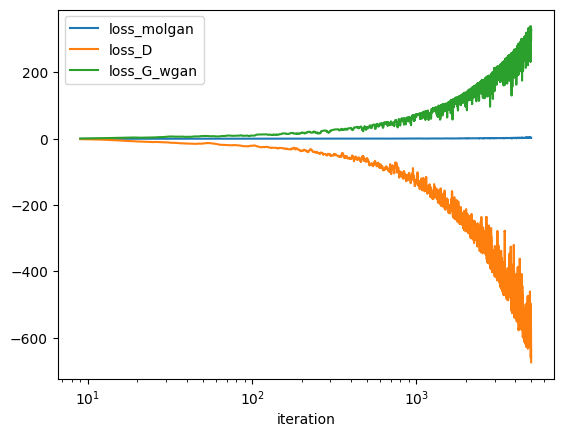

In [22]:
result_df=pd.DataFrame(result,index=["loss_molgan", "loss_V", "loss_D", "loss_G_wgan", "loss_RL", "loss_sum"]).T
ax=result_df.drop(columns=['loss_sum','loss_V','loss_RL']).rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-8,8))
ax.set_xlabel("iteration")

Text(0.5, 0, 'iteration')

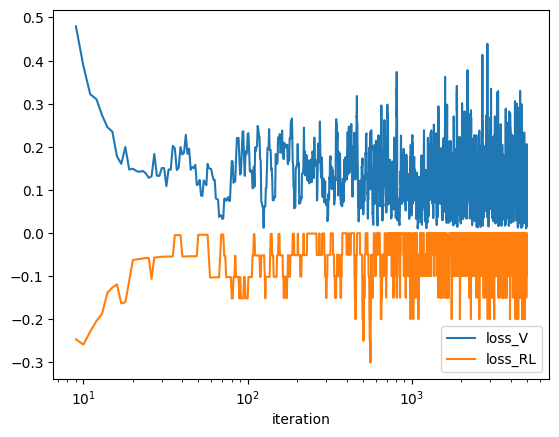

In [23]:
ax=result_df[['loss_V','loss_RL']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

Text(0.5, 1.0, 'loss_molgan')

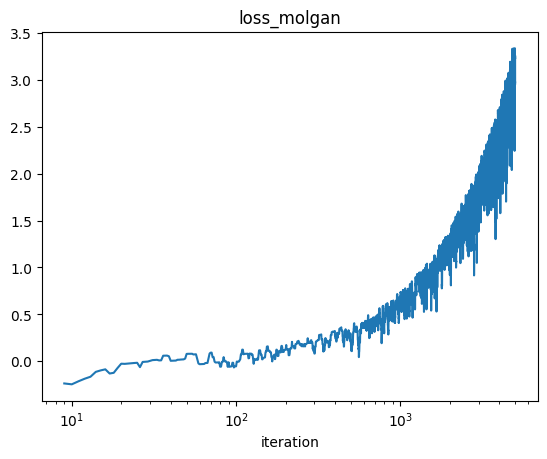

In [29]:
ax=result_df['loss_molgan'].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-10,10))
ax.set_xlabel("iteration")
ax.set_title("loss_molgan")

Text(0.5, 0, 'iteration')

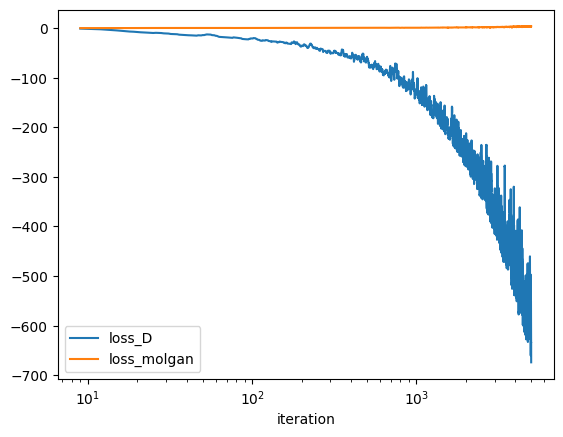

In [25]:
ax=result_df[['loss_D','loss_molgan']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

In [ ]:
GP_LAMBDA

In [ ]:
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        tmpmol=(mol_from_graph(*sampled_graph,print_errors=False))
        tmp.set_description(f'{sampled_graph[1][...,1:,:,:].sum()}')
        if tmpmol is not None:
            display(tmpmol)

In [27]:
best_mol=None
best_score=-100
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        try:
            tmp_score=reward(mol_from_graph(*sampled_graph,strict=False)).item()
        except:
            tmp_score=0
        if (tmp_score)>best_score:
            best_score=tmp_score
            best_mol=sampled_graph
            tmp.set_description(f'{best_score} {sampled_graph[1][...,1:,:,:].sum()}')
            #display(mol_from_graph(*best_mol,strict=False))

0 54.0:  15%|██████████▏                                                         | 1489/10000 [00:02<00:17, 498.79it/s]

KeyboardInterrupt



In [ ]:
mol_from_graph(*sampled_graph,strict=False)

In [ ]:
mol_from_graph(*best_mol,strict=False)

In [ ]:
with torch.no_grad():
    print(solver.R(sampled_graph).item())

In [ ]:
from IPython.display import display
for generated_graph in zip(*generated):
    tmp=(sample_gumbel(*generated_graph))
    break

In [ ]:
mol_from_graph(*tmp,print_errors=True)

WGAN-GP formula

$\underset{G}{\min}\underset{D}{\max}{[D(x)-D(G(z))+\lambda(\nabla_\hat{x}||D(\hat{x})||_2-1)^2]};x\sim X;z\sim p(z)$